In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  Setup

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import keras
from keras.datasets import mnist
from keras.layers import *
from keras.layers import LeakyReLU
from keras.models import Sequential , Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

Pepare Dataset

In [5]:
(X_train,_),(_,_) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train = (X_train-127.5)/127.5

print(X_train.min())
print(X_train.max())

-1.0
1.0


In [8]:
Total_epochs = 50
Batch_size = 256
Half_batch = 128

No_of_Batches = int(X_train.shape[0]/Batch_size)

noise_dim = 100
adam = Adam( lr = 2e-4, beta_1 = 0.5)

Generator Model : Upsampling

In [13]:
from keras.engine import input_spec
generator = Sequential()
generator.add(Dense(units=7*7*128, input_shape = (noise_dim,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#(7,7,128) --> (14,14,64)
generator.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# (14,14,64) --> (28,28,1)
generator.add(Conv2DTranspose(1,(3,3),strides=(2,2),padding='same', activation='tanh'))

generator.compile(loss=keras.losses.binary_crossentropy, optimizer = adam)

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 64)       

Descriminator : Downsampling

In [16]:
# (14,14,64) <-- (28,28,1)

descriminator = Sequential()
descriminator.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding= 'same', input_shape = (28,28,1)))
descriminator.add(LeakyReLU(0.2))

#(14,14,64) --> (7,7,128)
descriminator.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding= 'same'))
descriminator.add(LeakyReLU(0.2))

#(7,7,128) --> 6272
descriminator.add(Flatten())
descriminator.add(Dense(100))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dense(1, activation='sigmoid'))

descriminator.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)
descriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_9 (Dense)             (None, 100)               627300    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 100)              

## Combined Model

In [17]:
descriminator.trainable = False
gan_input = Input(shape = (noise_dim,))
generated_image = generator(gan_input)
gan_output = descriminator(generated_image)

# Functional API
model = Model(gan_input, gan_output)
model.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         708609    
                                                                 
 sequential_7 (Sequential)   (None, 1)                 701897    
                                                                 
Total params: 1,410,506
Trainable params: 708,225
Non-trainable params: 702,281
_________________________________________________________________


In [19]:
X_train = X_train.reshape(-1,28,28,1)

In [22]:
X_train.shape

(60000, 28, 28, 1)

In [30]:
def display_images(samples = 25):
  noise = np.random.normal(0,1,size = (samples, noise_dim))
  generated_image = generator.predict(noise)
  plt.figure(figsize =(10,10))
  for i in range(samples):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_image[i].reshape(28,28), cmap = "binary")
    plt.axis('off')
  plt.show()

4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.0028017468941517365, Generator loss 0.0047507846457326515
4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.0056712203300916236, Generator loss 0.00931959172599336
4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.008478382841134682, Generator loss 0.014022938716105925
4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.011402109239855383, Generator loss 0.018621112546350203
4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.014293490312038323, Generator loss 0.023299594210763264
4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.01701688078733591, Generator loss 0.02794514558254144
4/4 [==============================] - 0s 2ms/step
Epoch1, Disc loss0.01988001027677813, Generator loss 0.03253936003416012
4/4 [==============================] - 0s 3ms/step
Epoch1, Disc loss0.02260301102939834, Generator loss 0.03735294657894

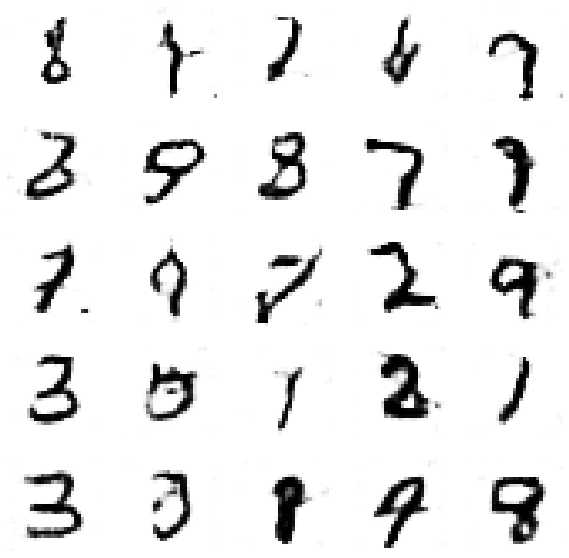

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.005389880548175584, Generator loss 0.010650880825825227
1/1 [==============================] - 0s 18ms/step


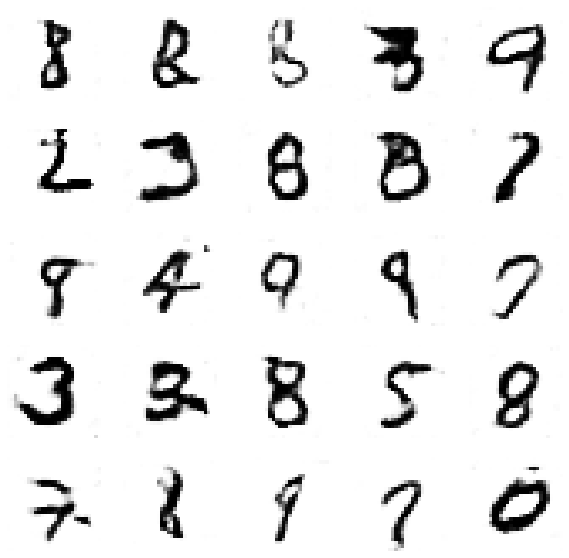

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.008155163536723862, Generator loss 0.01581714703486516
1/1 [==============================] - 0s 15ms/step


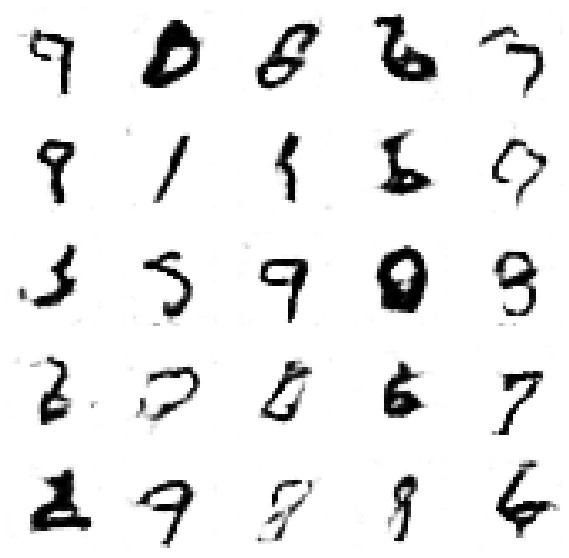

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.01071489952568315, Generator loss 0.021064887698898967
1/1 [==============================] - 0s 15ms/step


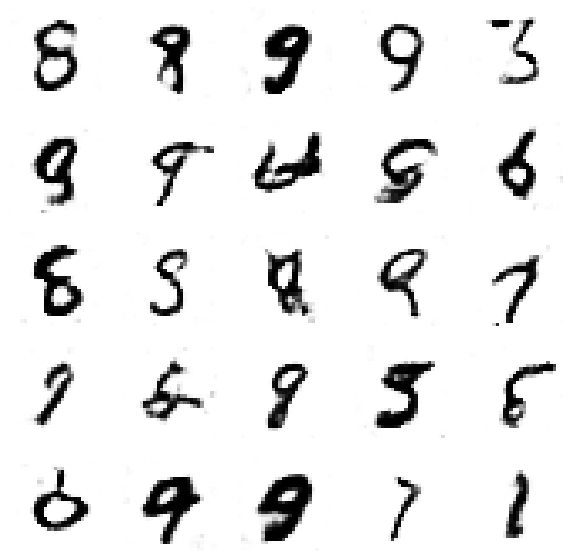

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.013369581128796961, Generator loss 0.026314720638796814
1/1 [==============================] - 0s 15ms/step


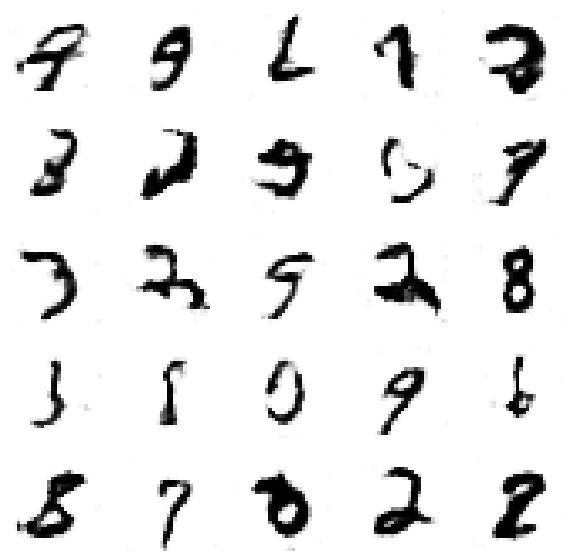

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.016040525629989102, Generator loss 0.03159194675266233
1/1 [==============================] - 0s 19ms/step


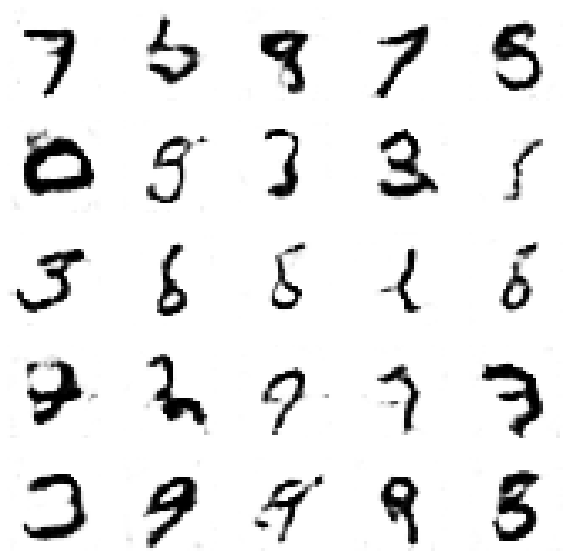

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.018623467630300768, Generator loss 0.036772730513515636
1/1 [==============================] - 0s 15ms/step


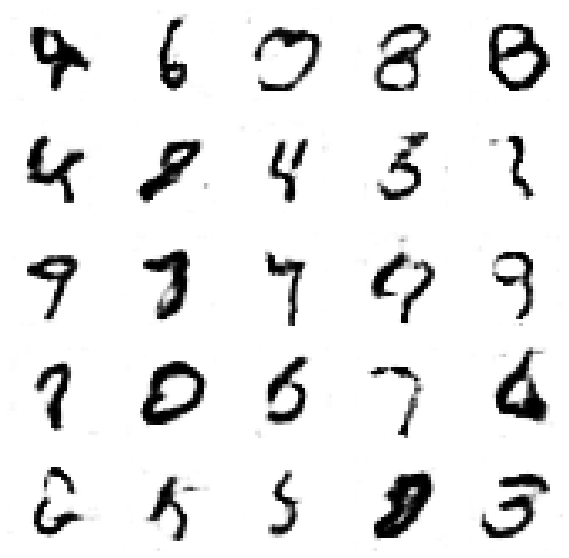

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.021190697884457745, Generator loss 0.04182926151487562
1/1 [==============================] - 0s 17ms/step


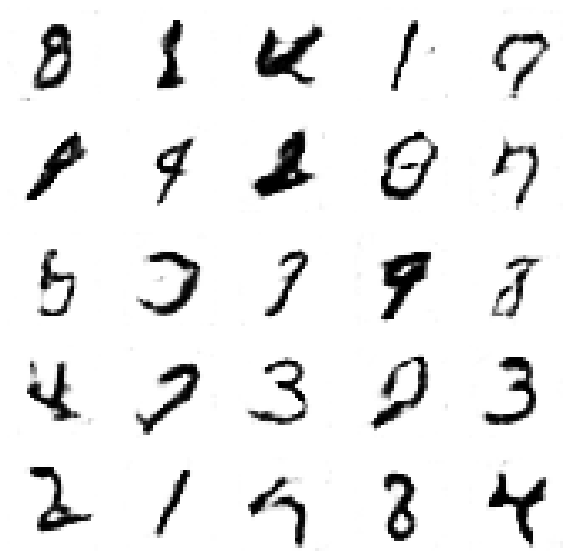

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.023915065213655815, Generator loss 0.04689830185001732
1/1 [==============================] - 0s 15ms/step


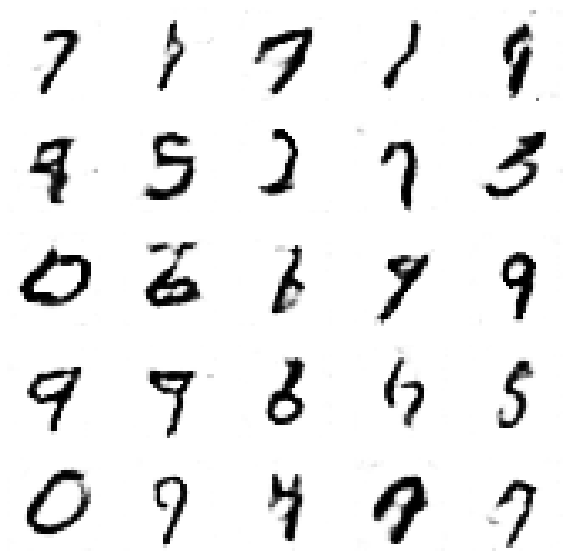

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.026587548992063247, Generator loss 0.05209688447479509
1/1 [==============================] - 0s 17ms/step


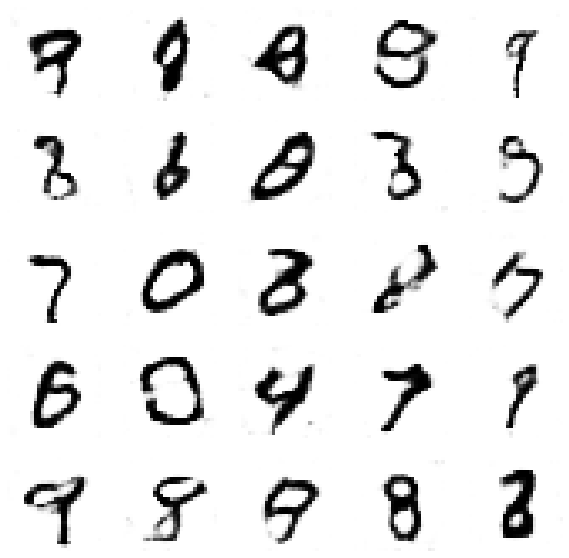

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.0292253109634432, Generator loss 0.057128012689769775
1/1 [==============================] - 0s 15ms/step


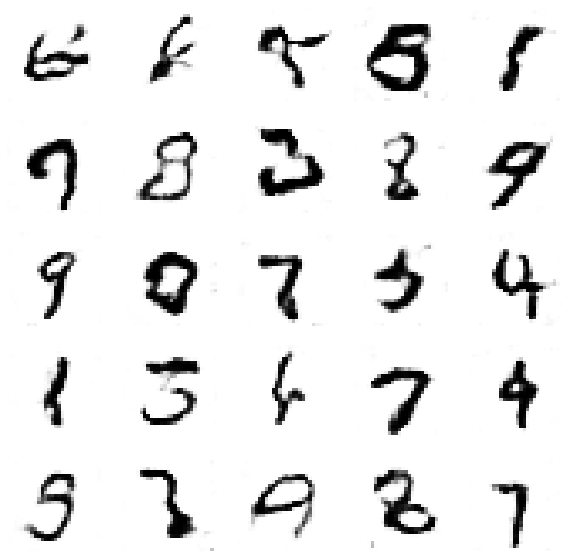

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.03176875972849691, Generator loss 0.06250634967771351
1/1 [==============================] - 0s 17ms/step


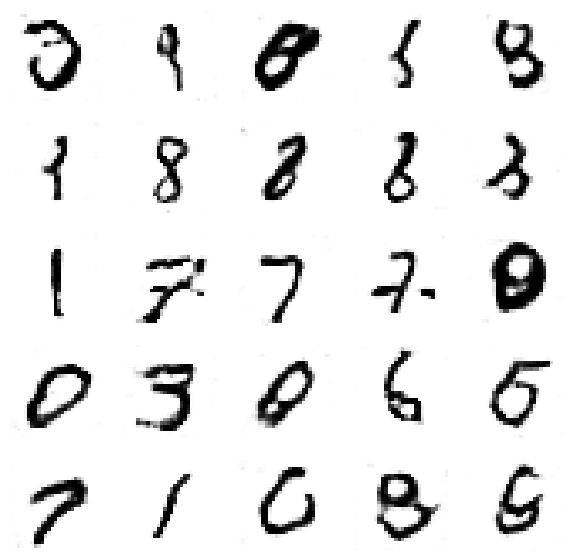

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.03446630891571697, Generator loss 0.06785911117863451
1/1 [==============================] - 0s 15ms/step


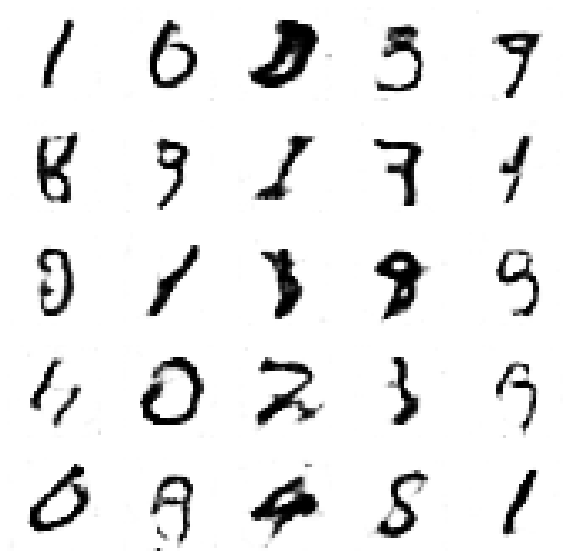

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.03715457474319344, Generator loss 0.07319053166951889
1/1 [==============================] - 0s 17ms/step


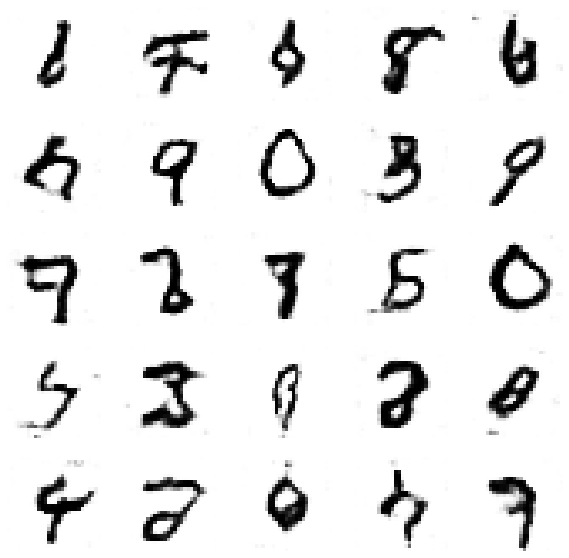

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.03974761030612848, Generator loss 0.07827388017605512
1/1 [==============================] - 0s 16ms/step


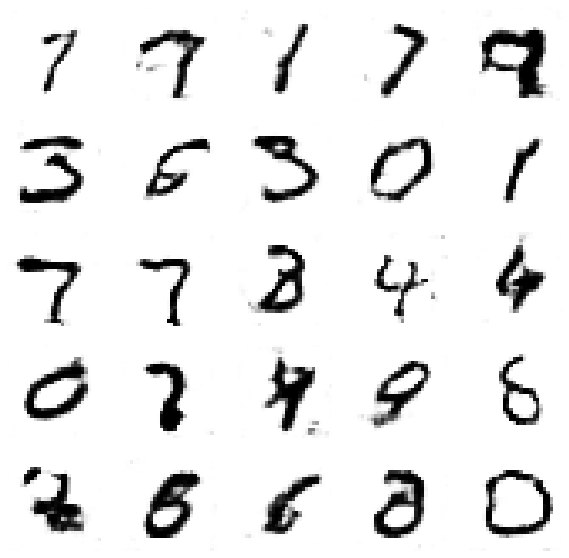

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.04224904849488511, Generator loss 0.08354852596918742
1/1 [==============================] - 0s 15ms/step


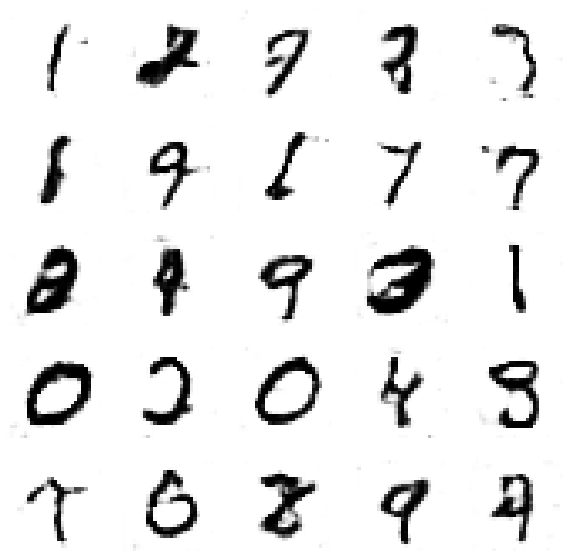

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.044903879109610856, Generator loss 0.0887029705903469
1/1 [==============================] - 0s 23ms/step


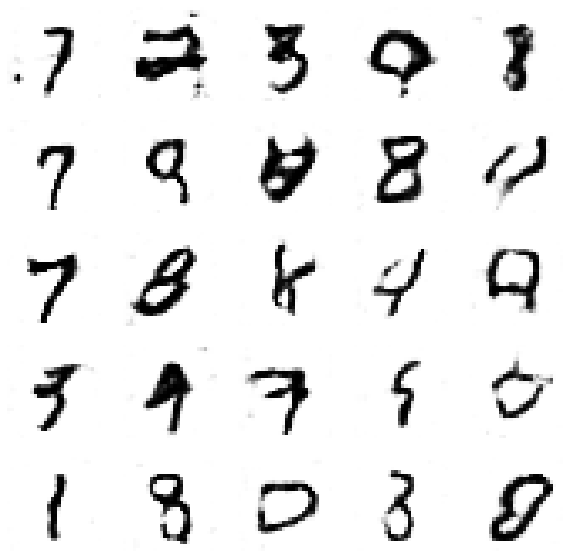

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.04743846423096127, Generator loss 0.09397184594064696
1/1 [==============================] - 0s 19ms/step


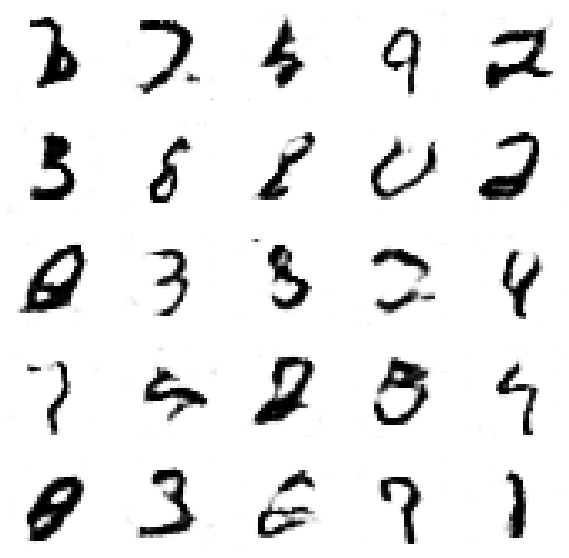

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.05014555793032687, Generator loss 0.09936449772272354
1/1 [==============================] - 0s 15ms/step


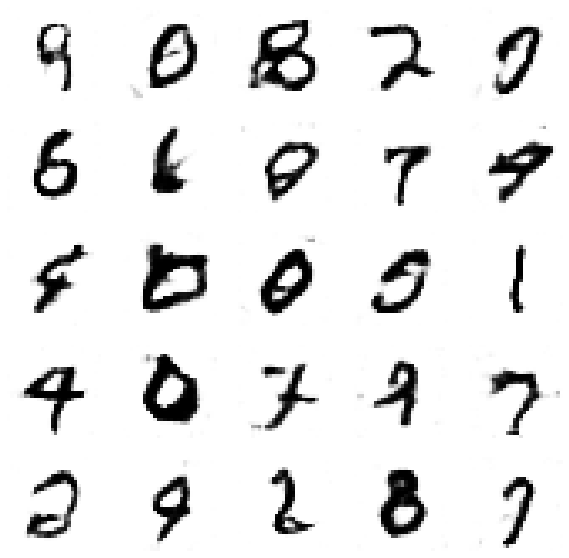

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.05283047972071884, Generator loss 0.10476800824841882
1/1 [==============================] - 0s 15ms/step


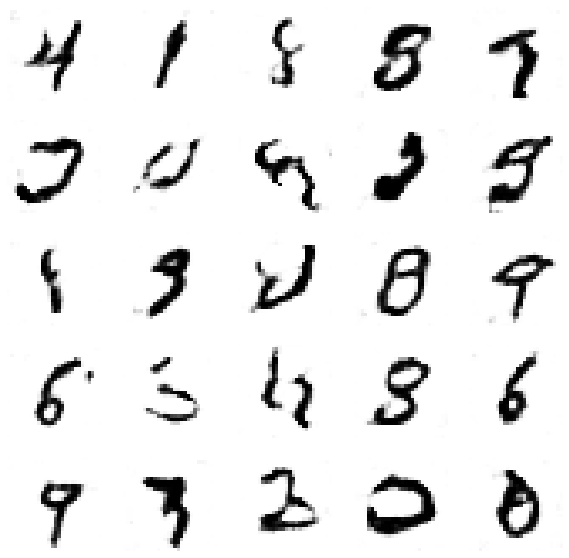

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.0554573231527948, Generator loss 0.11027237645581238
1/1 [==============================] - 0s 15ms/step


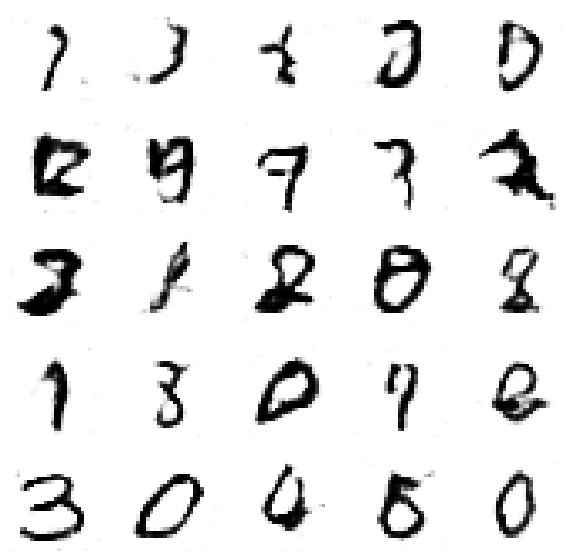

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.05806292536166998, Generator loss 0.11564222258380336
1/1 [==============================] - 0s 21ms/step


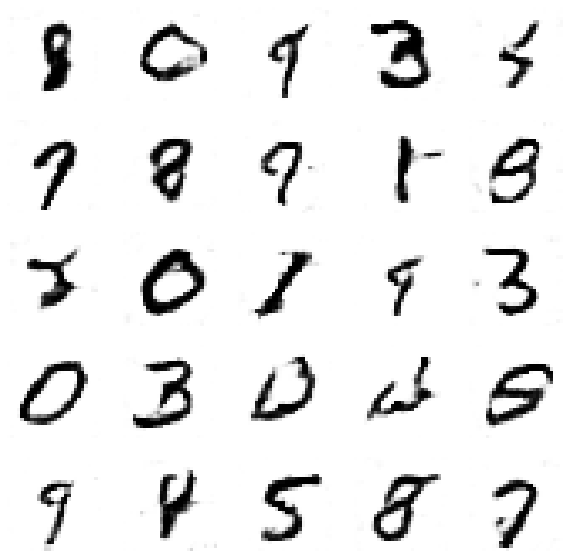

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.06074667441793996, Generator loss 0.12101176865080483
1/1 [==============================] - 0s 21ms/step


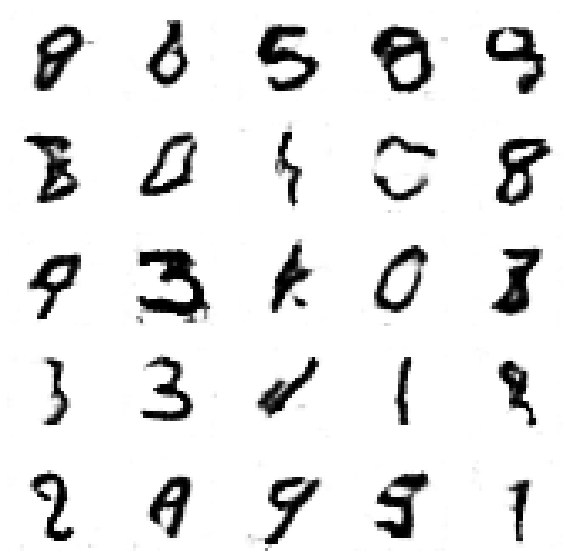

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.06324310008531962, Generator loss 0.12606112060383853
1/1 [==============================] - 0s 15ms/step


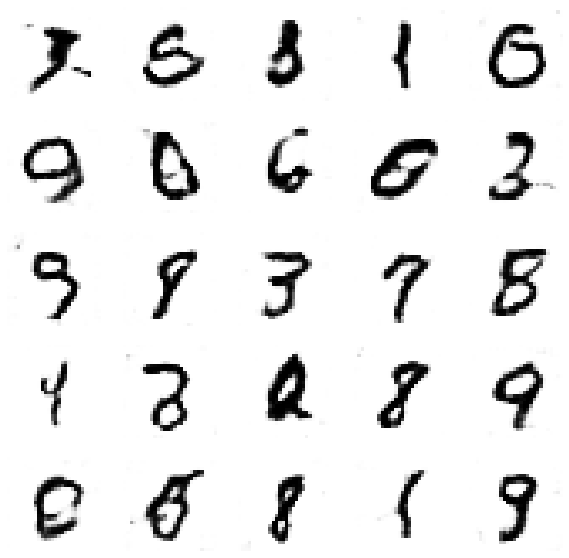

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.06595044583082199, Generator loss 0.13122395063057923
1/1 [==============================] - 0s 20ms/step


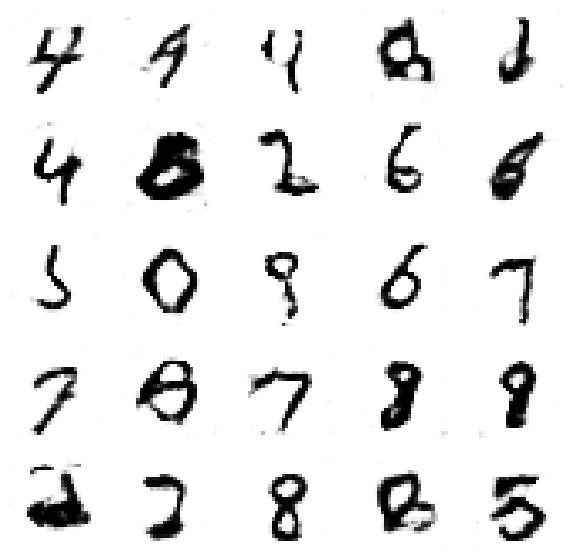

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.06873928093247944, Generator loss 0.13644271324842405
1/1 [==============================] - 0s 20ms/step


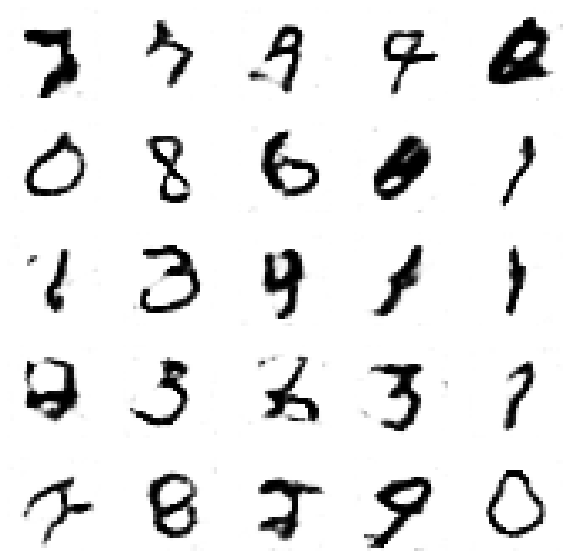

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.07128332383357562, Generator loss 0.14170729757374168
1/1 [==============================] - 0s 15ms/step


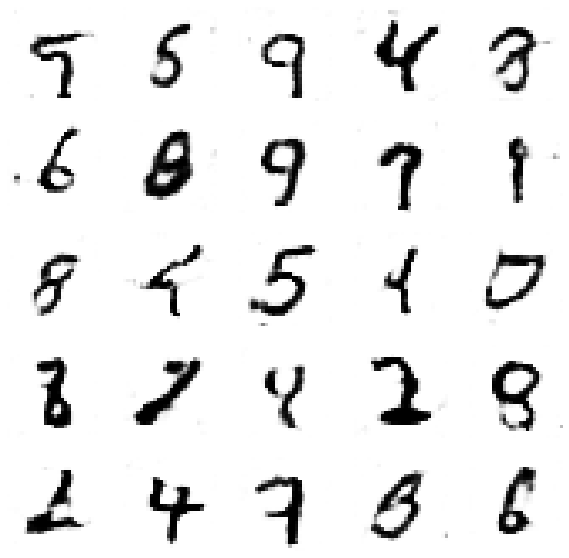

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.07402752575456586, Generator loss 0.1467524338991214
1/1 [==============================] - 0s 15ms/step


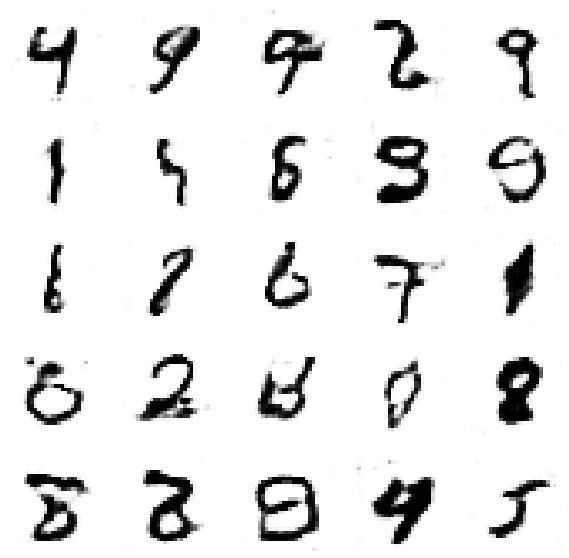

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.07666385014597167, Generator loss 0.15196263586354053
1/1 [==============================] - 0s 20ms/step


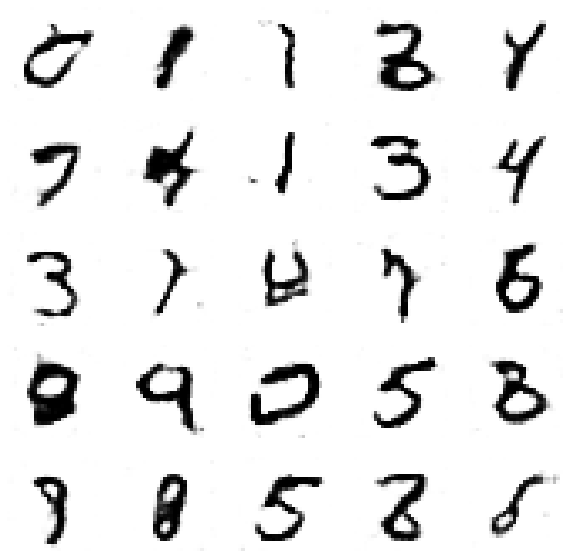

4/4 [==============================] - 0s 2ms/step
Epoch10, Disc loss0.07921740890313418, Generator loss 0.15744386575160882
1/1 [==============================] - 0s 15ms/step


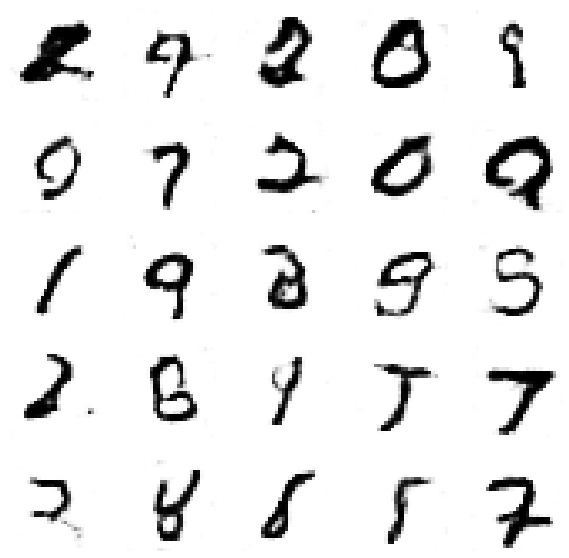

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.08177868436034928, Generator loss 0.1629317611710638
1/1 [==============================] - 0s 15ms/step


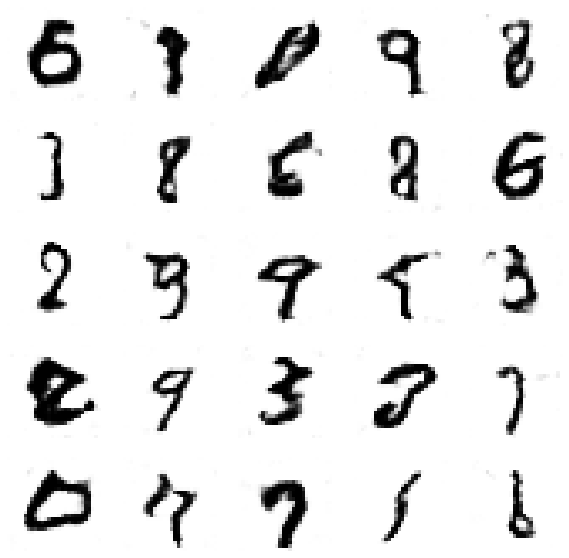

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.08441974929510018, Generator loss 0.16824503026456913
1/1 [==============================] - 0s 15ms/step


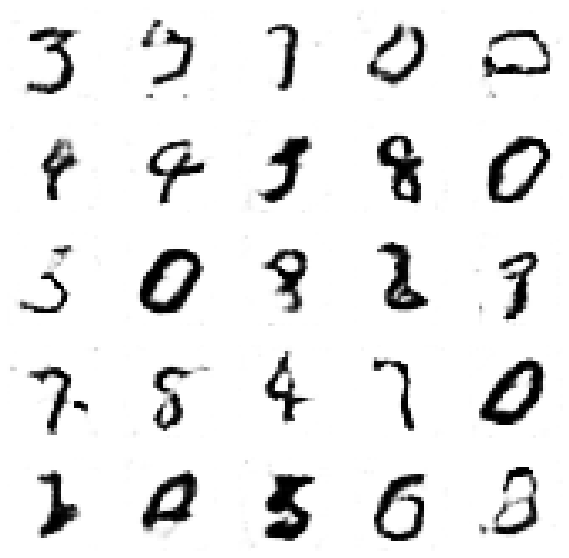

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.0871960860159662, Generator loss 0.17343103987538916
1/1 [==============================] - 0s 31ms/step


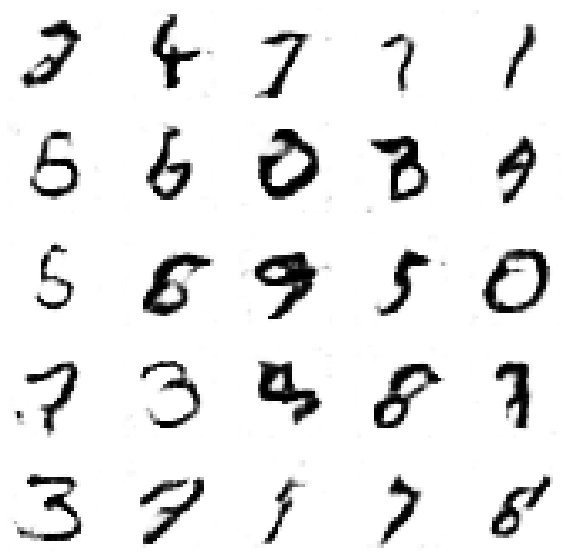

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.08984054644138385, Generator loss 0.17851156658596462
1/1 [==============================] - 0s 17ms/step


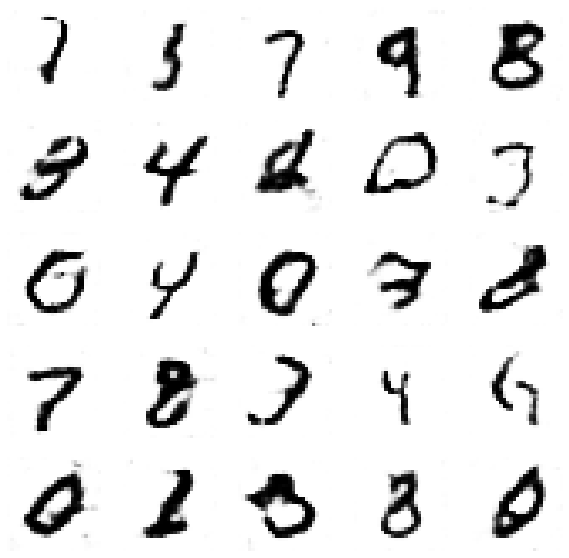

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.0924879040600907, Generator loss 0.183698538531605
1/1 [==============================] - 0s 15ms/step


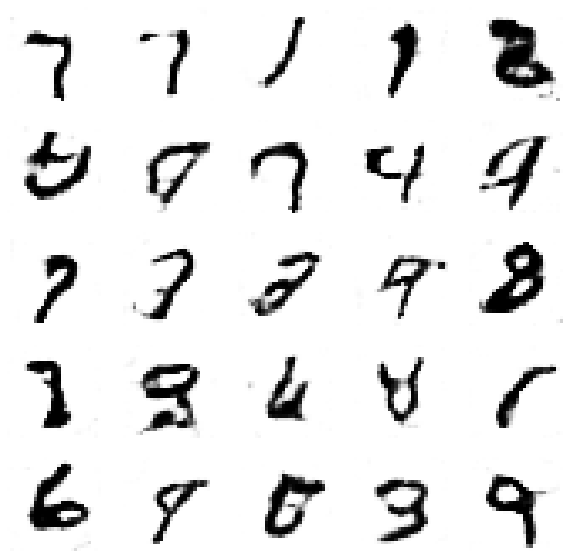

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.09510220682773834, Generator loss 0.18905381412587613
1/1 [==============================] - 0s 20ms/step


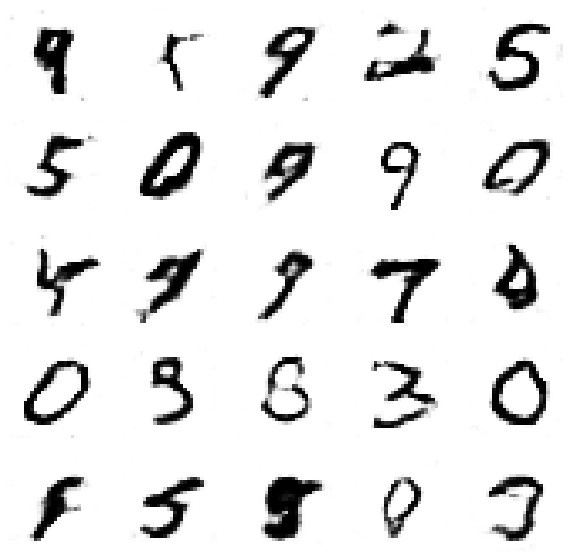

4/4 [==============================] - 0s 8ms/step
Epoch10, Disc loss0.09772024513819279, Generator loss 0.1942654730927231
1/1 [==============================] - 0s 15ms/step


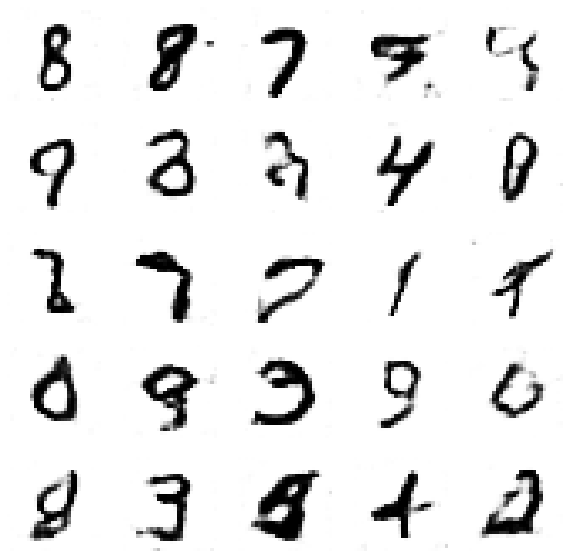

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.10040471492669521, Generator loss 0.1995943845846714
1/1 [==============================] - 0s 17ms/step


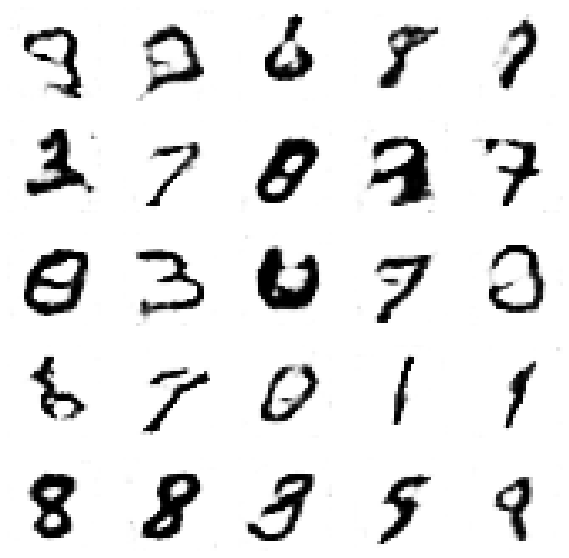

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.10296818429333532, Generator loss 0.20499388529704168
1/1 [==============================] - 0s 15ms/step


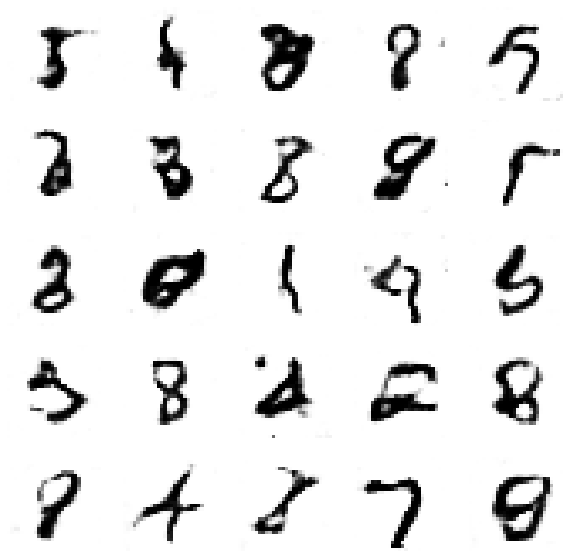

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.10565050691366196, Generator loss 0.21009486608016184
1/1 [==============================] - 0s 16ms/step


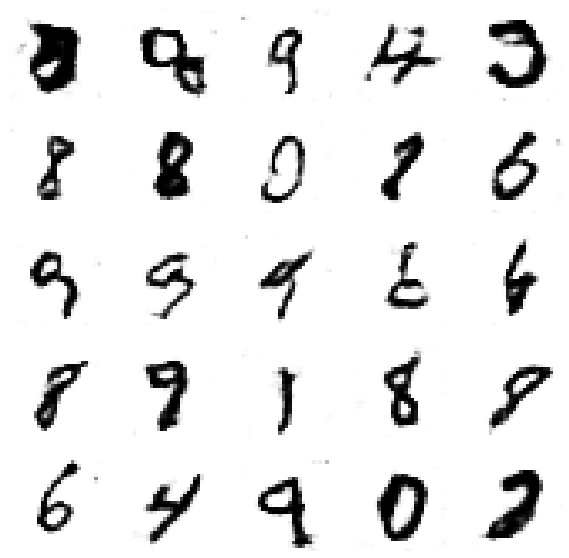

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.10817433403343217, Generator loss 0.21516017985140157
1/1 [==============================] - 0s 24ms/step


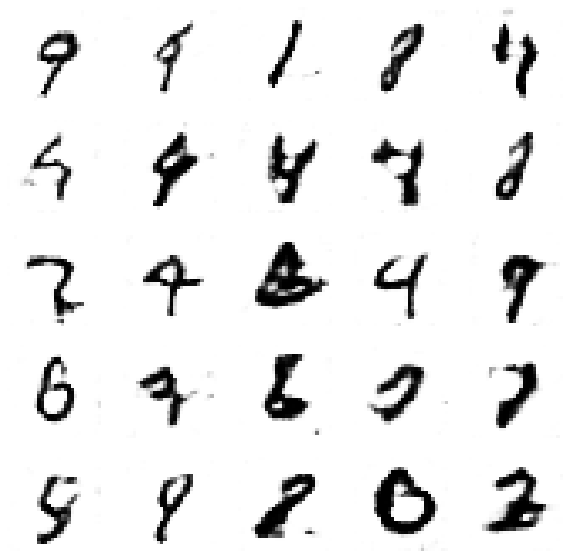

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.11078967886348055, Generator loss 0.22028136253356934
1/1 [==============================] - 0s 15ms/step


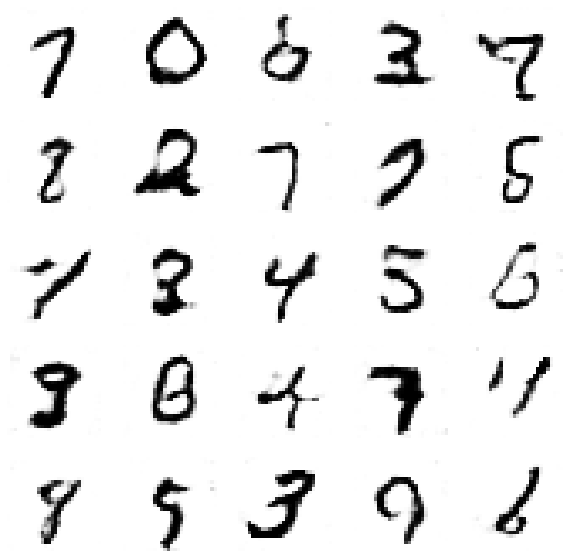

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.11343103296991087, Generator loss 0.22560935244600996
1/1 [==============================] - 0s 23ms/step


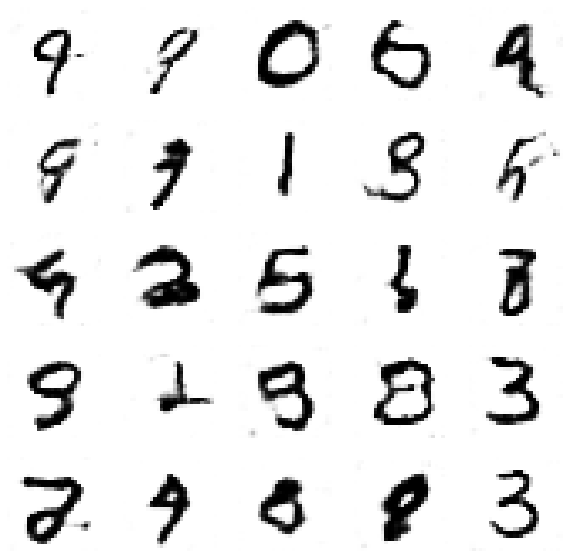

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.11603198557073234, Generator loss 0.2309189729201488
1/1 [==============================] - 0s 15ms/step


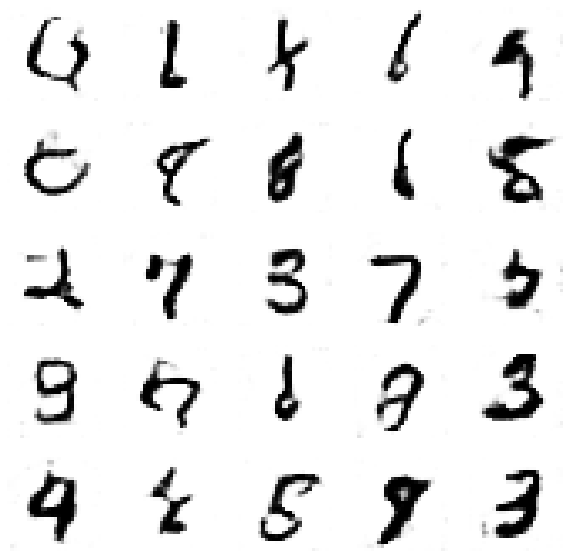

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.11876319380652191, Generator loss 0.23613141184179193
1/1 [==============================] - 0s 17ms/step


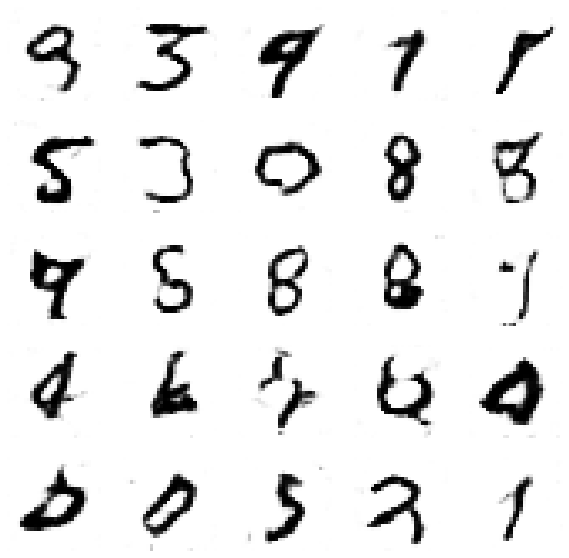

4/4 [==============================] - 0s 7ms/step
Epoch10, Disc loss0.12156105035135889, Generator loss 0.24131728950728717
1/1 [==============================] - 0s 20ms/step


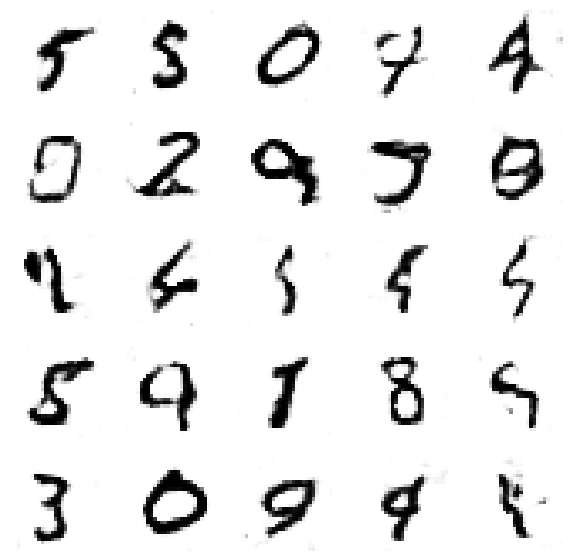

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.12426400598552492, Generator loss 0.24648368562388623
1/1 [==============================] - 0s 23ms/step


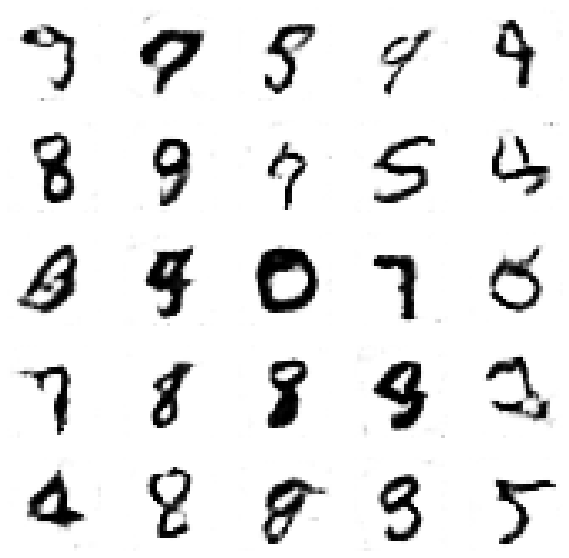

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.1268119388538548, Generator loss 0.2516164514753554
1/1 [==============================] - 0s 15ms/step


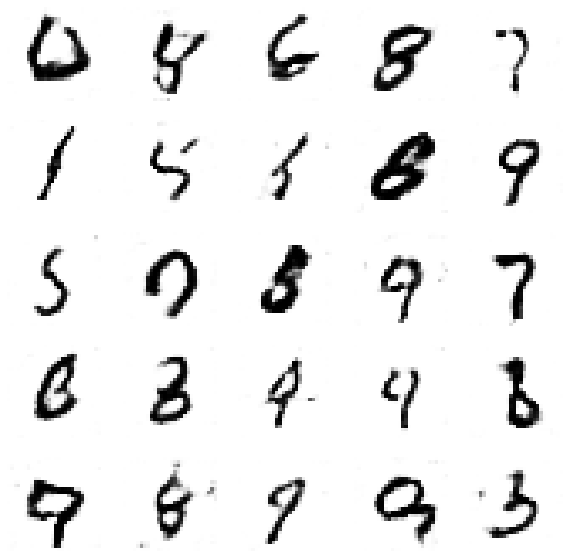

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.12949389977078152, Generator loss 0.25691435377821964
1/1 [==============================] - 0s 26ms/step


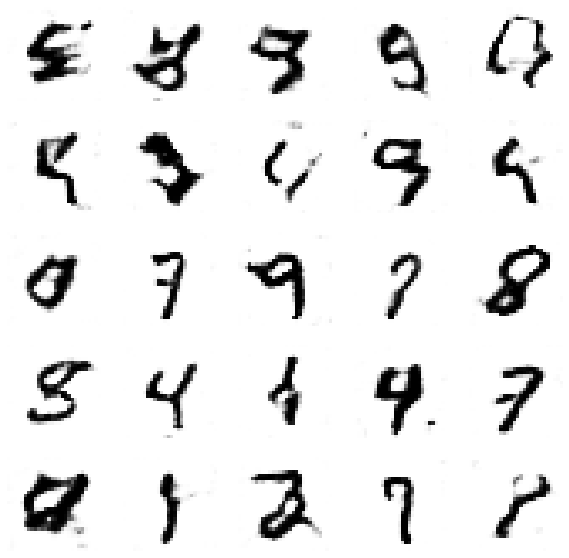

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.13208249039374864, Generator loss 0.26210486277555806
1/1 [==============================] - 0s 15ms/step


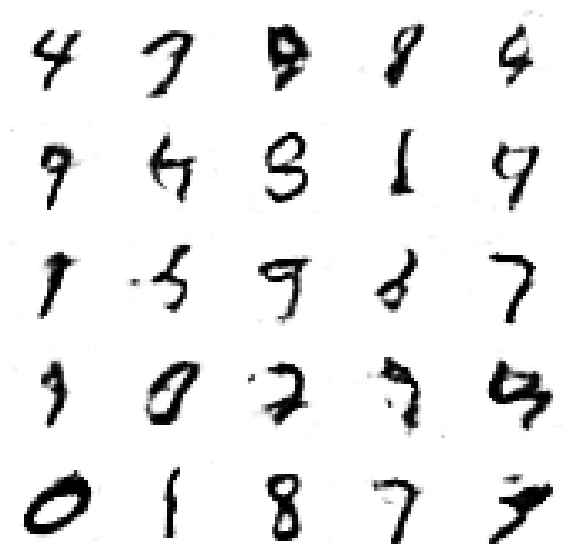

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.13472767231556085, Generator loss 0.26757267703357923
1/1 [==============================] - 0s 21ms/step


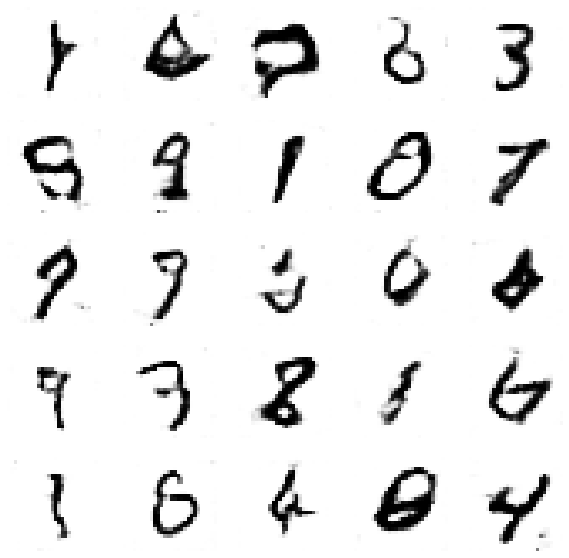

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.13733775104977128, Generator loss 0.2729782497780955
1/1 [==============================] - 0s 18ms/step


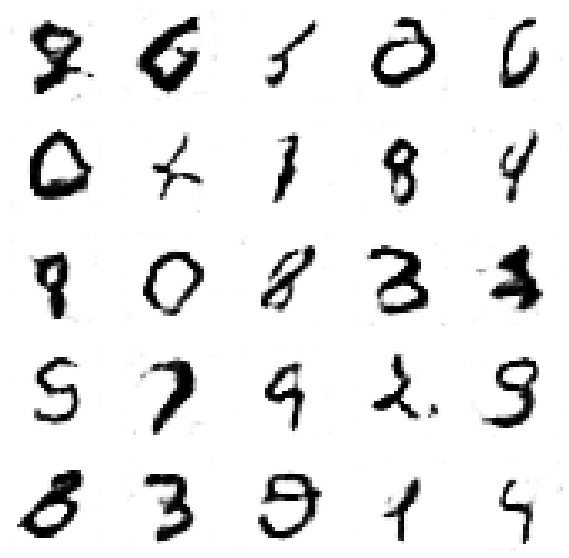

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.14001842741018686, Generator loss 0.2780544961619581
1/1 [==============================] - 0s 15ms/step


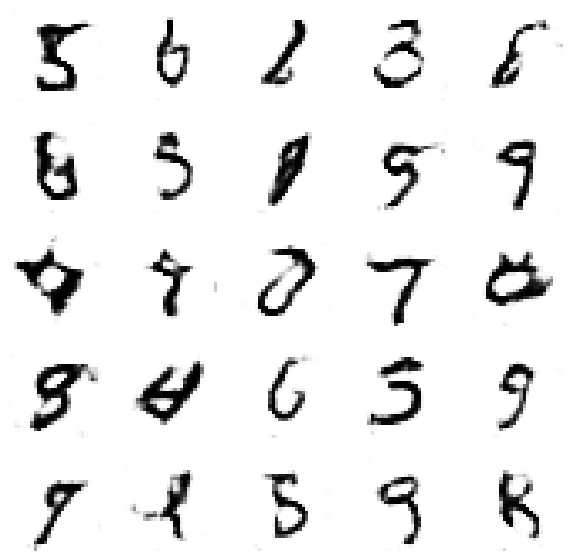

4/4 [==============================] - 0s 7ms/step
Epoch10, Disc loss0.14264580422741735, Generator loss 0.28319977898883003
1/1 [==============================] - 0s 19ms/step


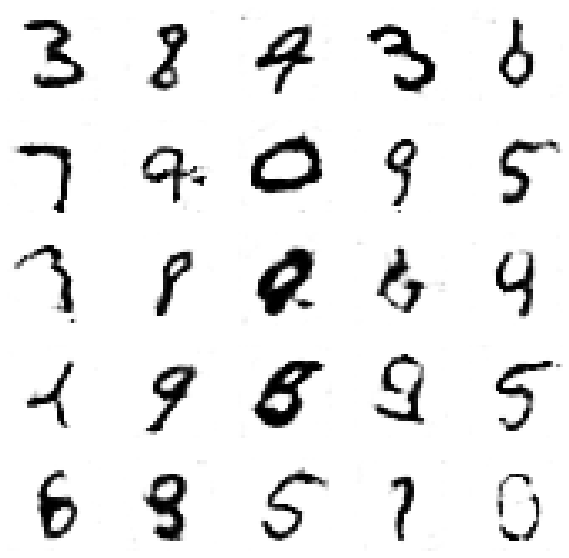

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.1451876294027027, Generator loss 0.28855202850113565
1/1 [==============================] - 0s 15ms/step


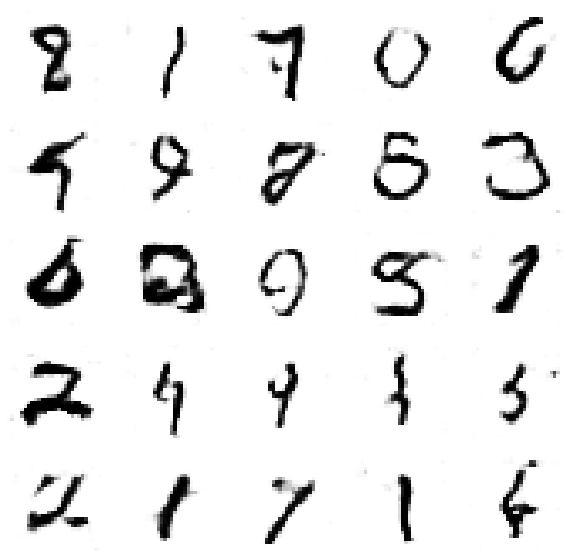

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.14782917212981445, Generator loss 0.29376815017471963
1/1 [==============================] - 0s 15ms/step


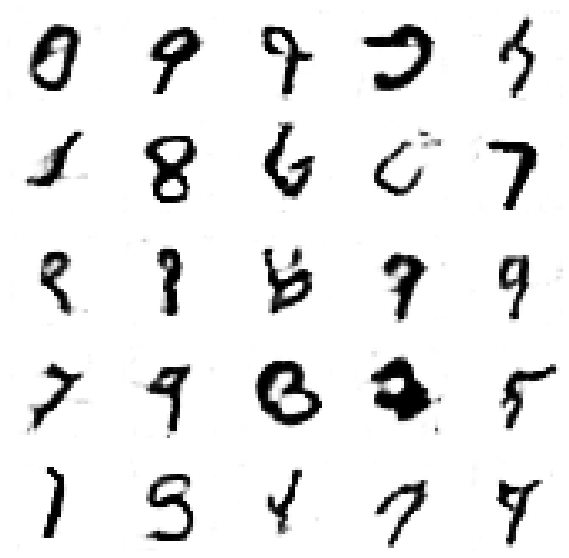

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.1502738566352771, Generator loss 0.2990090424179012
1/1 [==============================] - 0s 17ms/step


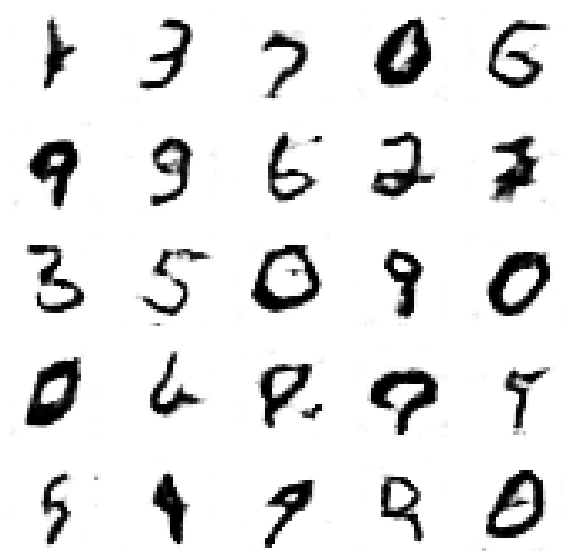

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.15296883390754715, Generator loss 0.30405509777558154
1/1 [==============================] - 0s 16ms/step


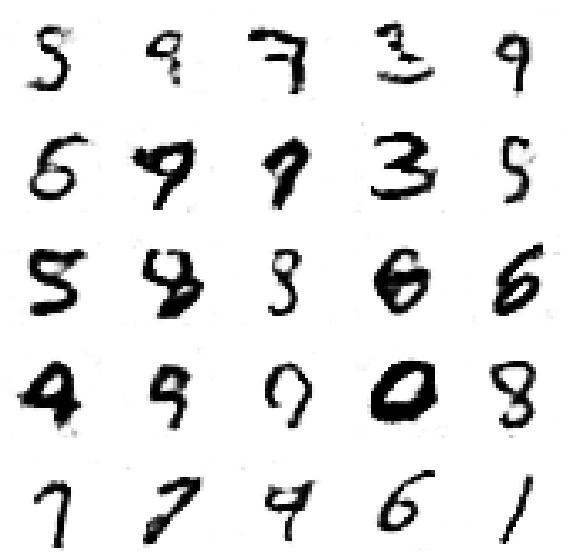

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.15552358450288448, Generator loss 0.3093252752581213
1/1 [==============================] - 0s 15ms/step


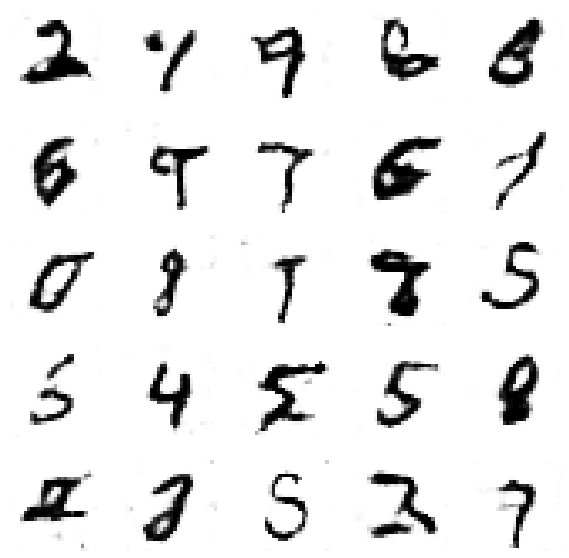

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.15810852357719699, Generator loss 0.3145405013337095
1/1 [==============================] - 0s 19ms/step


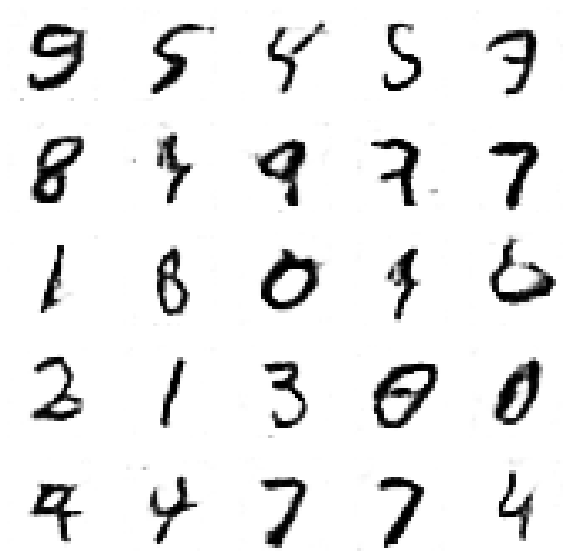

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.1607122831364982, Generator loss 0.3195734665944026
1/1 [==============================] - 0s 32ms/step


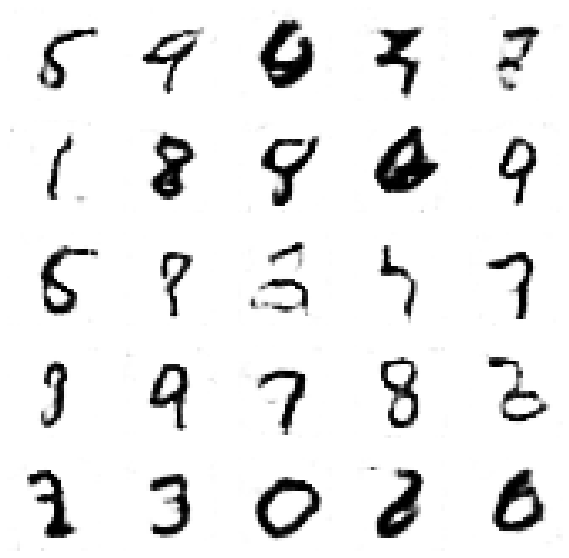

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.16328549754415822, Generator loss 0.3246969168002789
1/1 [==============================] - 0s 17ms/step


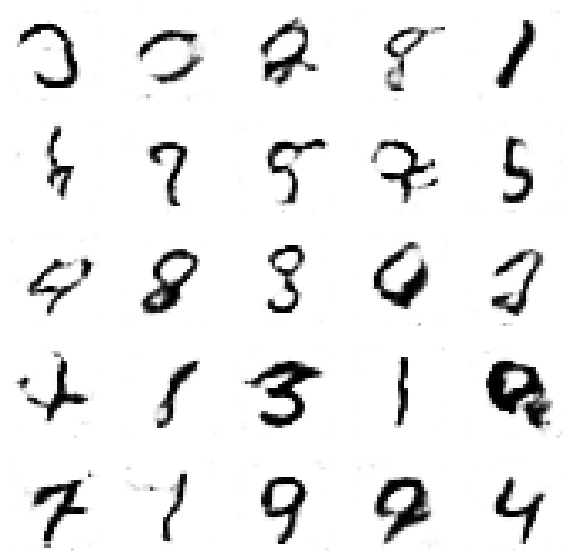

4/4 [==============================] - 0s 2ms/step
Epoch10, Disc loss0.16600773044121572, Generator loss 0.3300160592437809
1/1 [==============================] - 0s 15ms/step


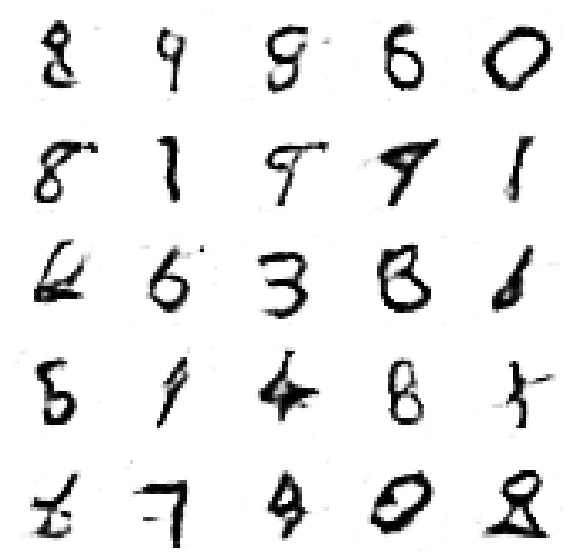

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.16864177788424695, Generator loss 0.3355354987657987
1/1 [==============================] - 0s 26ms/step


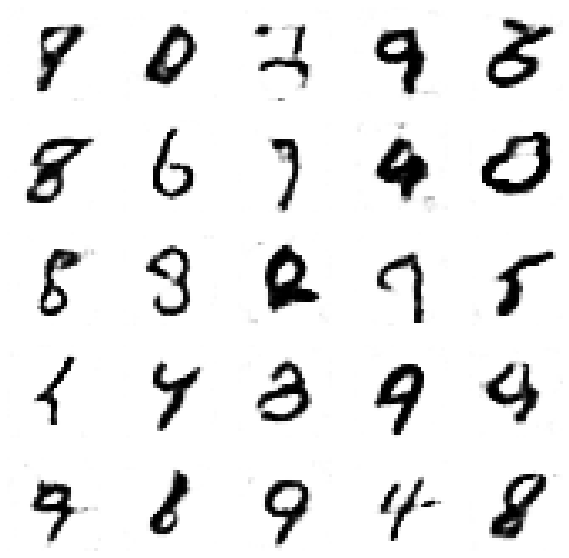

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.17134941273774856, Generator loss 0.3410137637048705
1/1 [==============================] - 0s 15ms/step


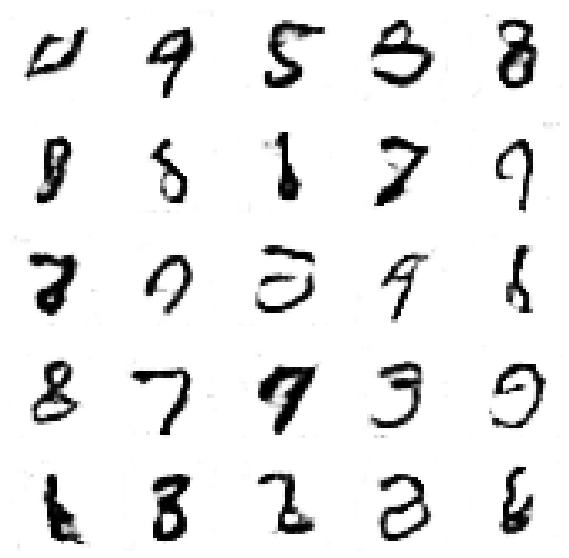

4/4 [==============================] - 0s 7ms/step
Epoch10, Disc loss0.17399107531095162, Generator loss 0.3462793582525009
1/1 [==============================] - 0s 27ms/step


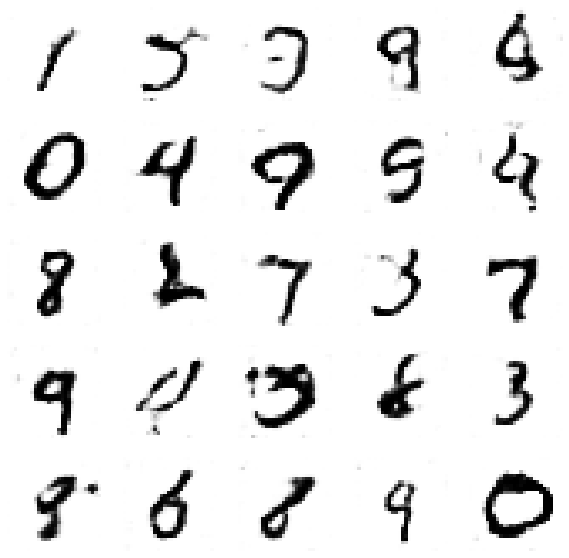

4/4 [==============================] - 0s 8ms/step
Epoch10, Disc loss0.17650753781836256, Generator loss 0.3514223103849297
1/1 [==============================] - 0s 17ms/step


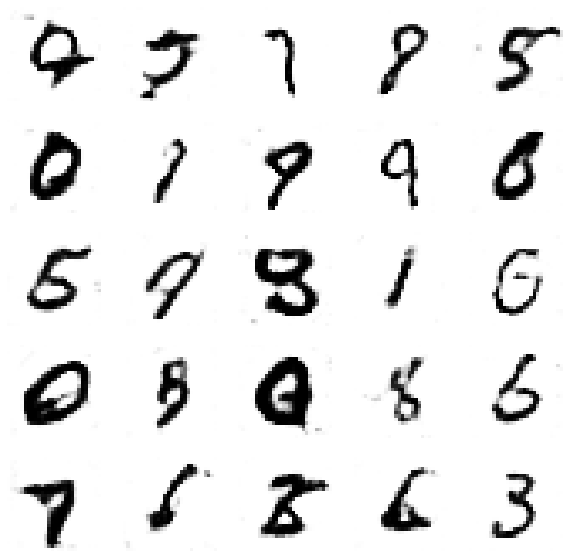

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.1791093620734337, Generator loss 0.35659531905100894
1/1 [==============================] - 0s 17ms/step


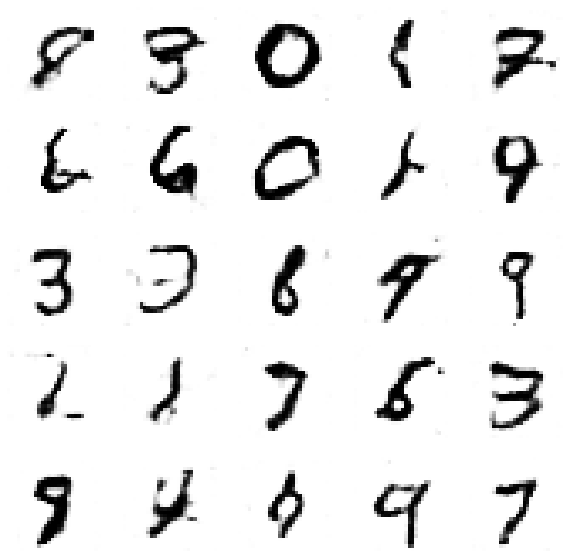

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.1817169492570763, Generator loss 0.36186954353609657
1/1 [==============================] - 0s 17ms/step


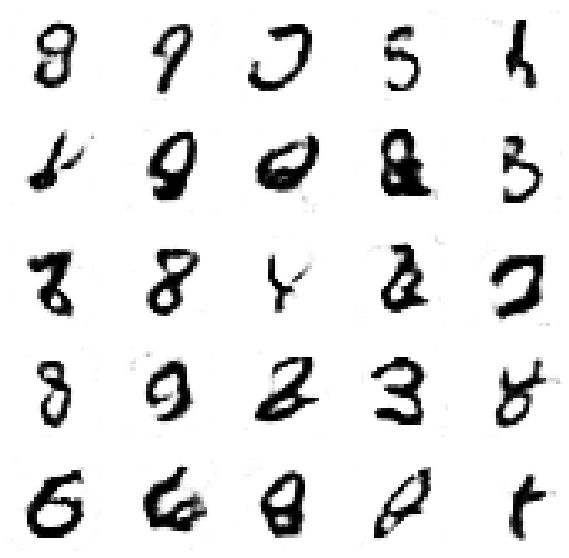

4/4 [==============================] - 0s 7ms/step
Epoch10, Disc loss0.18436057419858426, Generator loss 0.3670197215854612
1/1 [==============================] - 0s 25ms/step


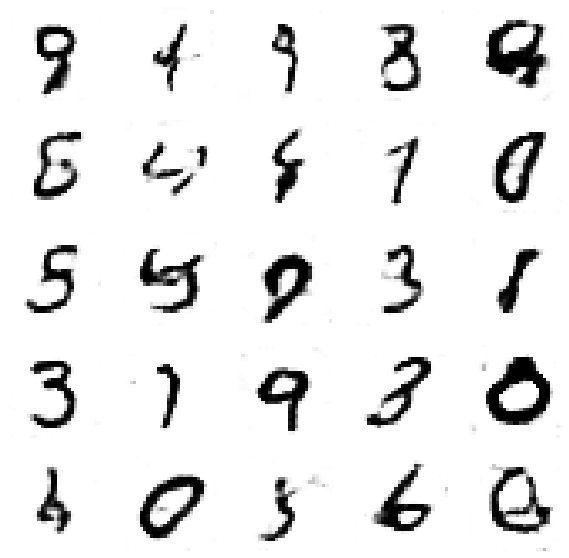

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.18693171887316257, Generator loss 0.37244838832790017
1/1 [==============================] - 0s 15ms/step


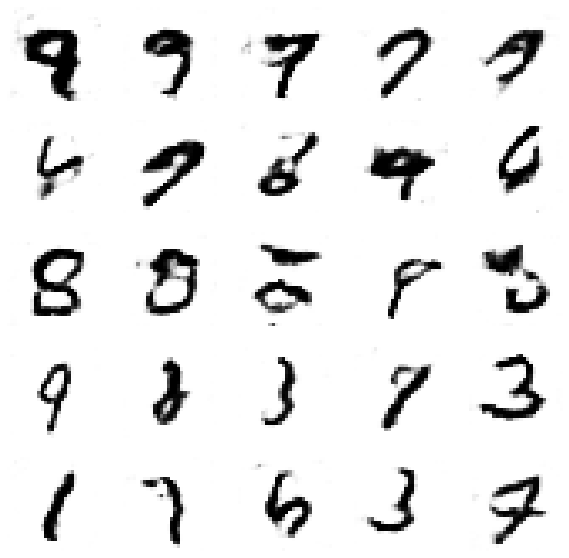

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.1894229490023393, Generator loss 0.37781382931603325
1/1 [==============================] - 0s 16ms/step


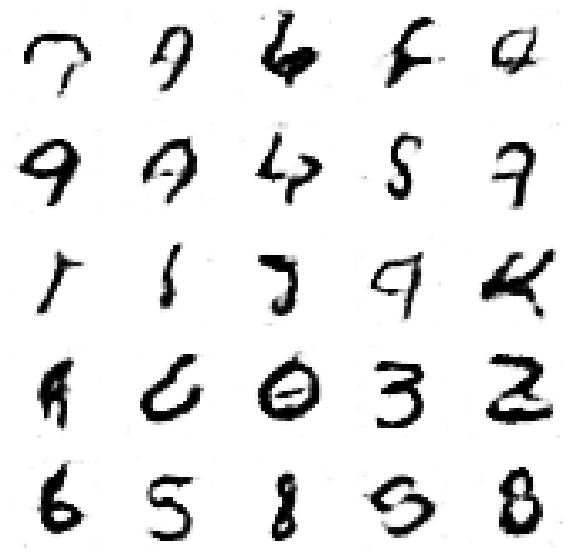

4/4 [==============================] - 0s 7ms/step
Epoch10, Disc loss0.19200194939079449, Generator loss 0.3832352869531028
1/1 [==============================] - 0s 15ms/step


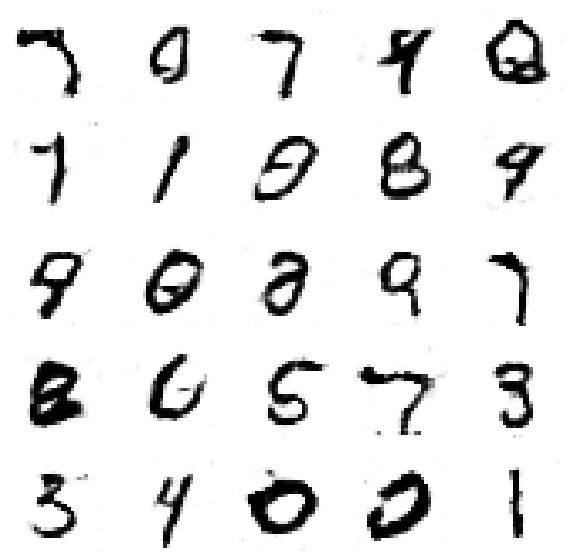

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.19457988071645427, Generator loss 0.3886105774814247
1/1 [==============================] - 0s 15ms/step


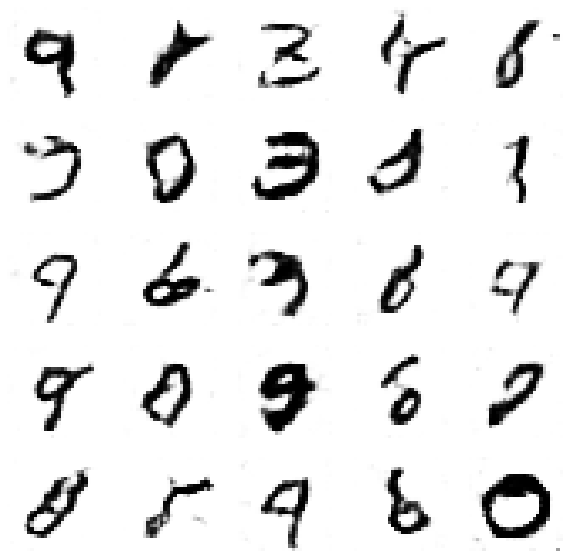

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.1971609707062061, Generator loss 0.39400211307737565
1/1 [==============================] - 0s 16ms/step


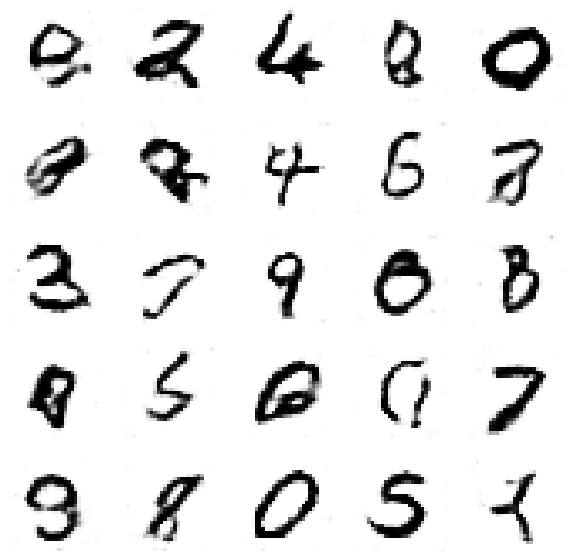

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.19983292606651273, Generator loss 0.3992406099270552
1/1 [==============================] - 0s 17ms/step


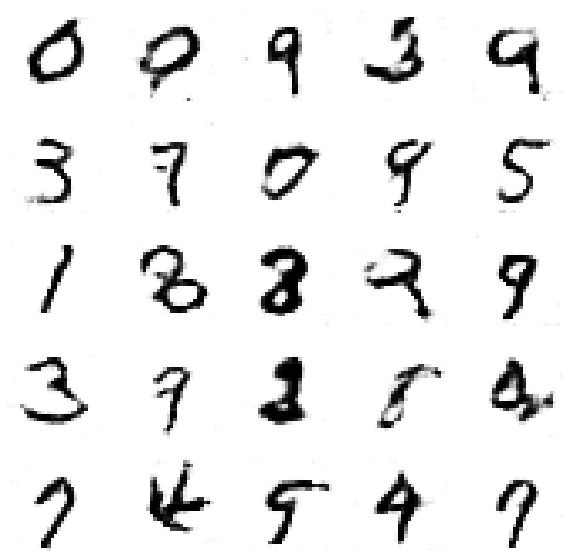

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.20240488508318225, Generator loss 0.40489231215582955
1/1 [==============================] - 0s 15ms/step


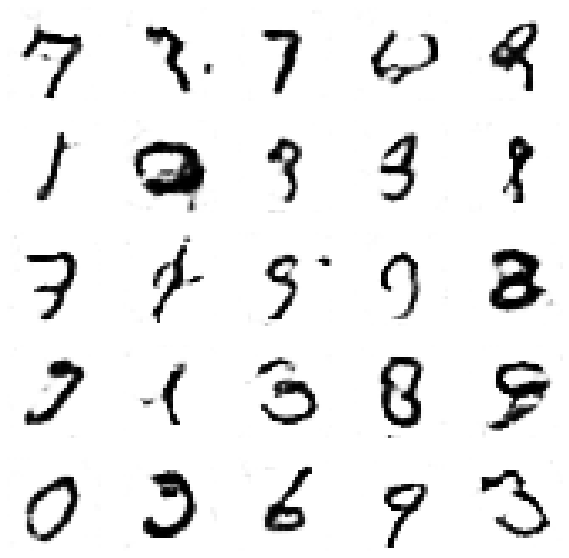

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.20495545494760203, Generator loss 0.410506218417078
1/1 [==============================] - 0s 18ms/step


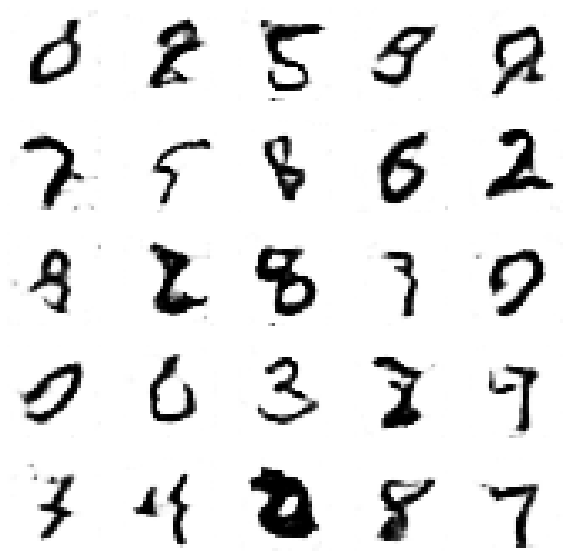

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.20754832118494898, Generator loss 0.41593563607615286
1/1 [==============================] - 0s 15ms/step


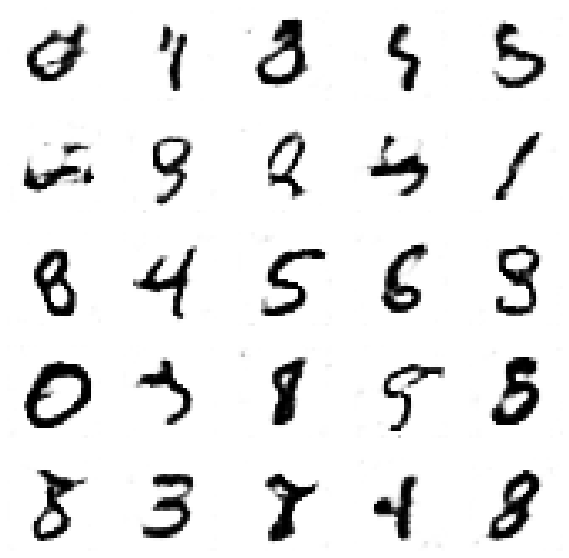

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.21018351181450054, Generator loss 0.42109212406680113
1/1 [==============================] - 0s 15ms/step


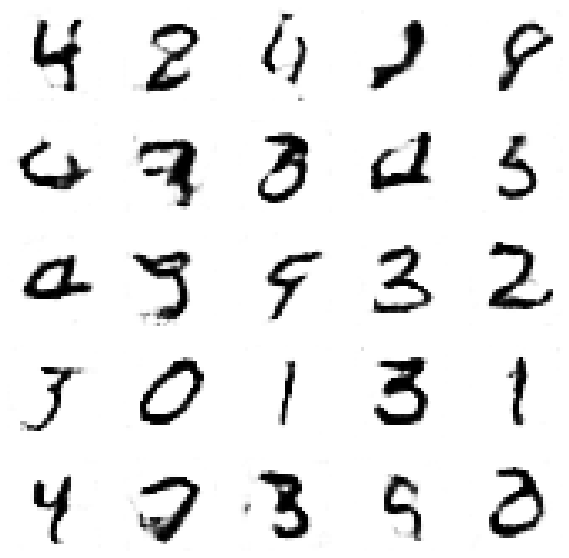

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.21282962321216226, Generator loss 0.42634025598183656
1/1 [==============================] - 0s 18ms/step


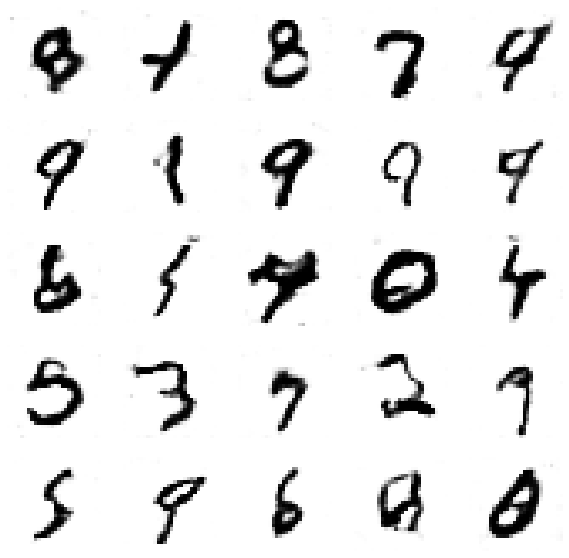

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.2155460359958502, Generator loss 0.43141426999344784
1/1 [==============================] - 0s 19ms/step


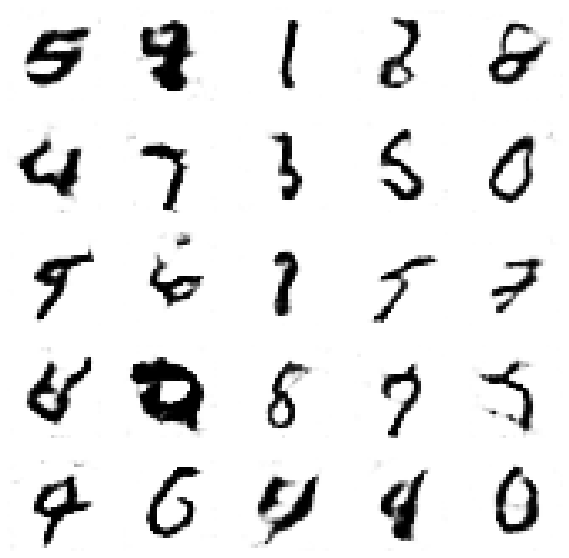

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.21814145402521148, Generator loss 0.4364656031641186
1/1 [==============================] - 0s 15ms/step


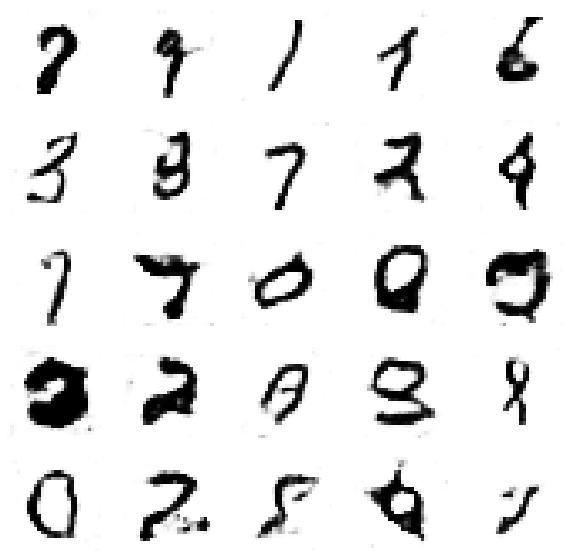

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.22067880248412108, Generator loss 0.44172585010528564
1/1 [==============================] - 0s 26ms/step


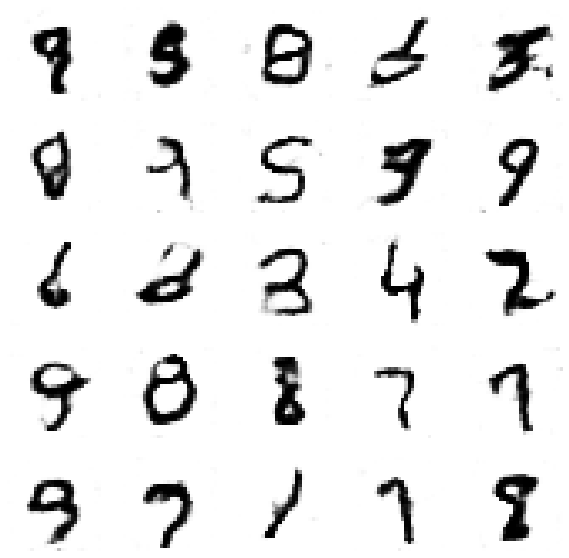

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.22339797019958496, Generator loss 0.447049848544292
1/1 [==============================] - 0s 18ms/step


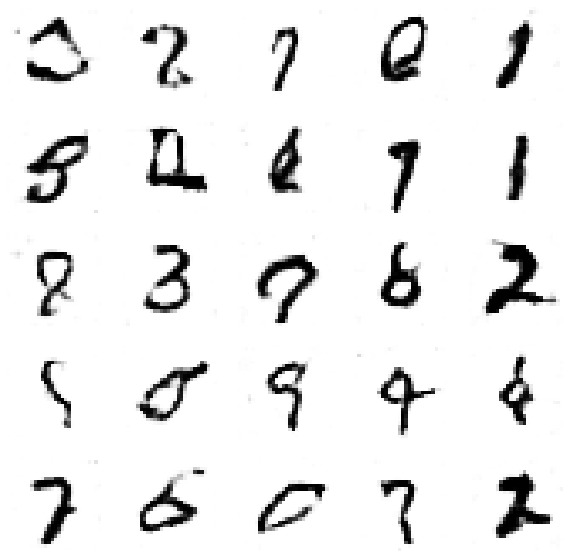

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.2258476639787356, Generator loss 0.45254110576760054
1/1 [==============================] - 0s 15ms/step


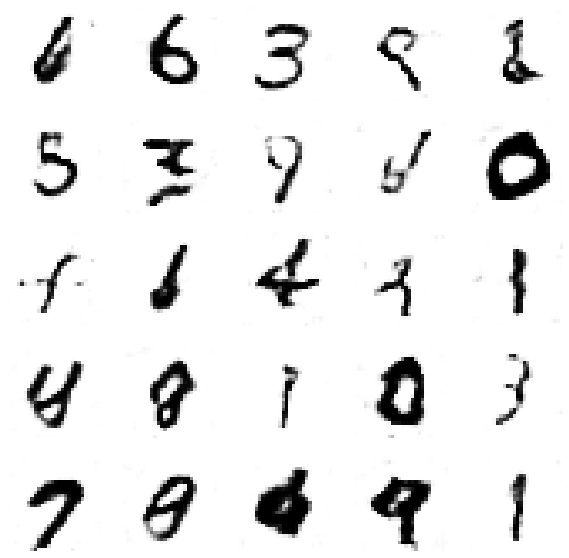

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.228539369490921, Generator loss 0.457859979226039
1/1 [==============================] - 0s 16ms/step


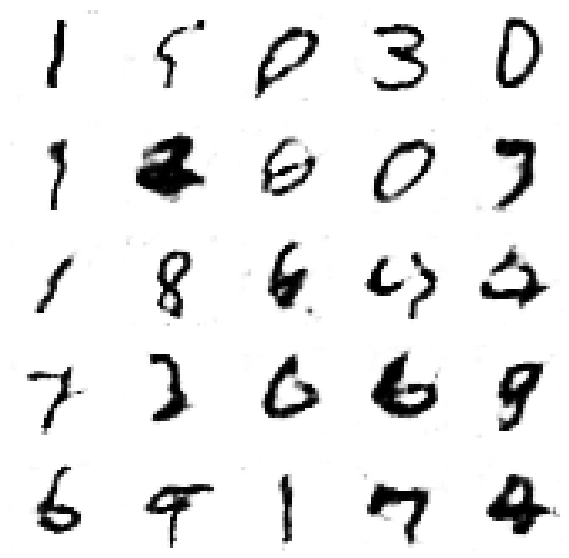

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.2312052372811187, Generator loss 0.4632044373414455
1/1 [==============================] - 0s 25ms/step


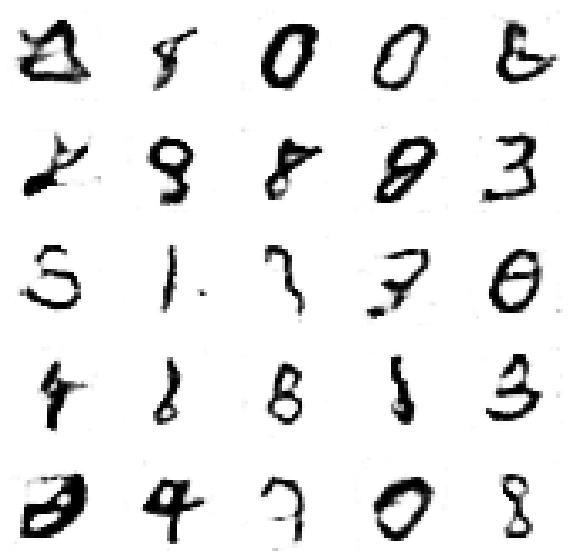

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.2338601923905886, Generator loss 0.4683193452337868
1/1 [==============================] - 0s 26ms/step


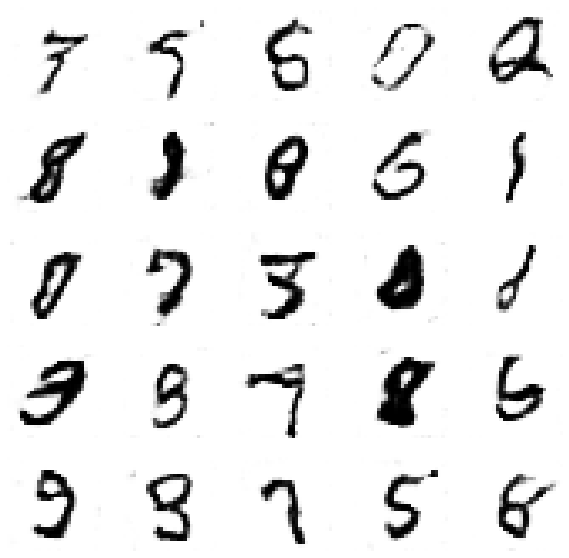

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.2363982475720919, Generator loss 0.4736897349357605
1/1 [==============================] - 0s 22ms/step


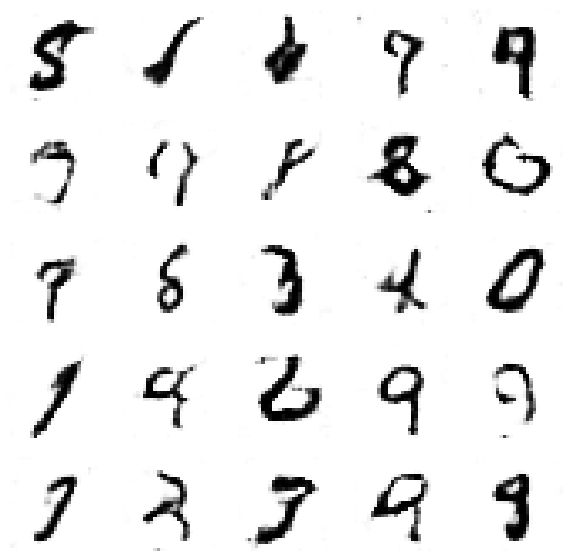

4/4 [==============================] - 0s 8ms/step
Epoch10, Disc loss0.23905759858779418, Generator loss 0.4790182668938596
1/1 [==============================] - 0s 20ms/step


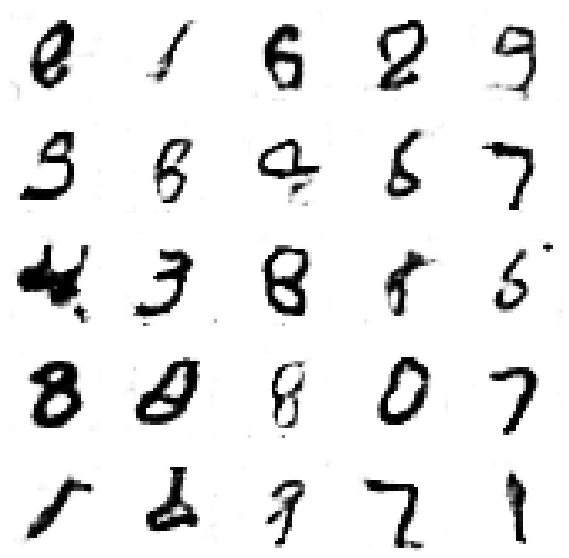

4/4 [==============================] - 0s 2ms/step
Epoch10, Disc loss0.24162194145540905, Generator loss 0.4843070659881983
1/1 [==============================] - 0s 18ms/step


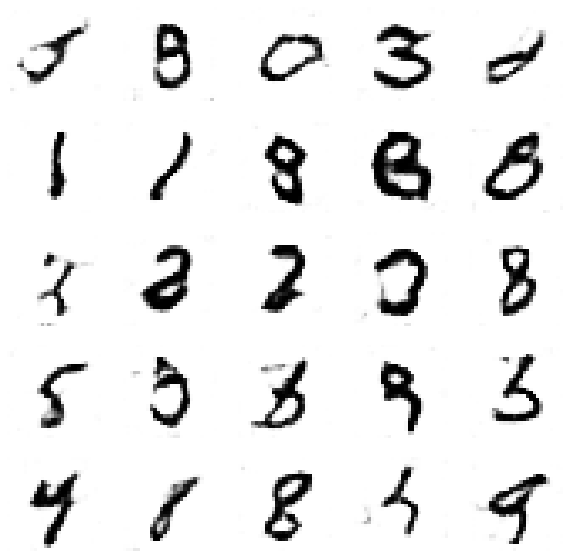

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.2441210772237207, Generator loss 0.48971893440963876
1/1 [==============================] - 0s 15ms/step


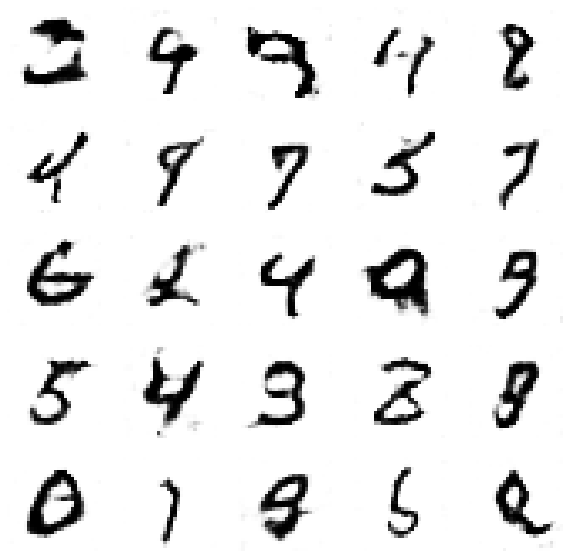

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.24675425313986266, Generator loss 0.495038748296917
1/1 [==============================] - 0s 15ms/step


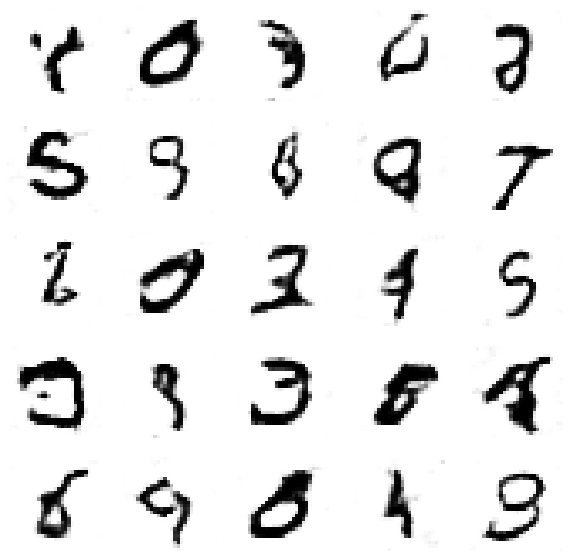

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.2492362195864702, Generator loss 0.5004772589756892
1/1 [==============================] - 0s 20ms/step


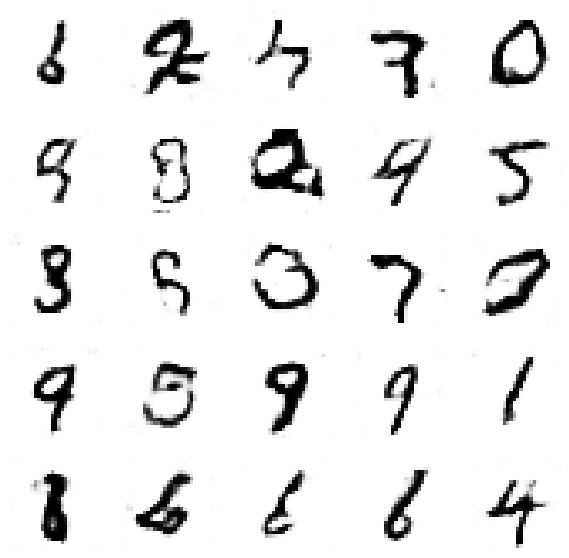

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.25198728100866336, Generator loss 0.5056585883482908
1/1 [==============================] - 0s 17ms/step


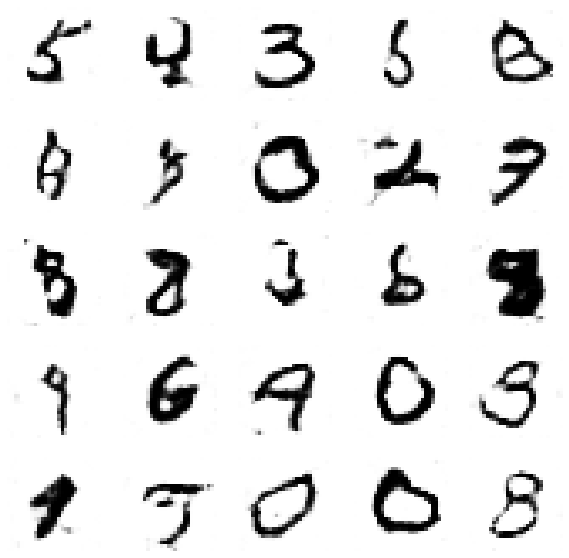

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.25466259422465265, Generator loss 0.5109030217187017
1/1 [==============================] - 0s 31ms/step


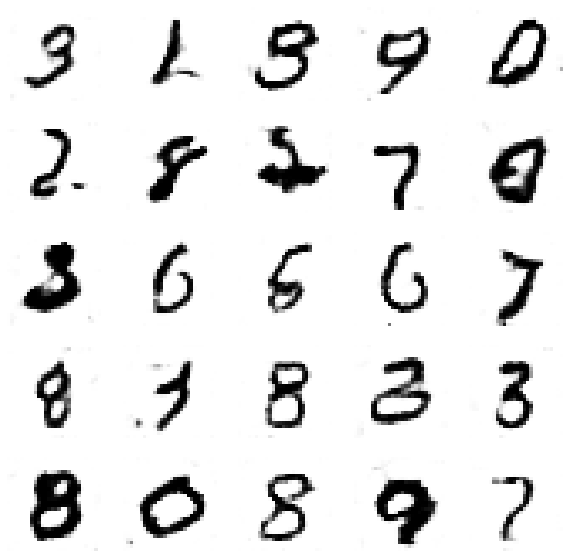

4/4 [==============================] - 0s 8ms/step
Epoch10, Disc loss0.25725437904525006, Generator loss 0.5161485799357423
1/1 [==============================] - 0s 22ms/step


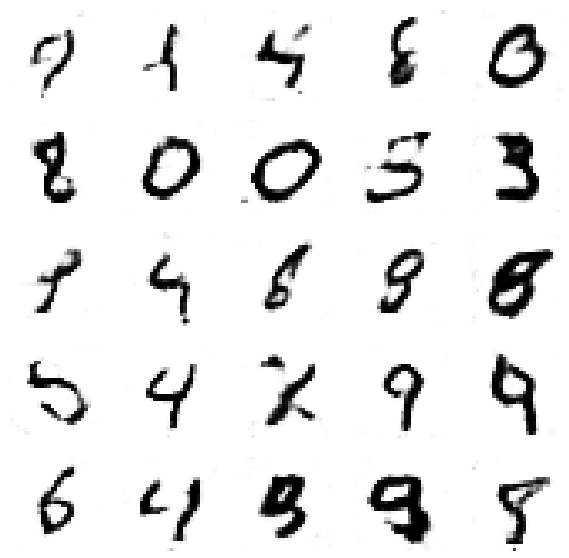

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.259986300753732, Generator loss 0.5214125666862879
1/1 [==============================] - 0s 18ms/step


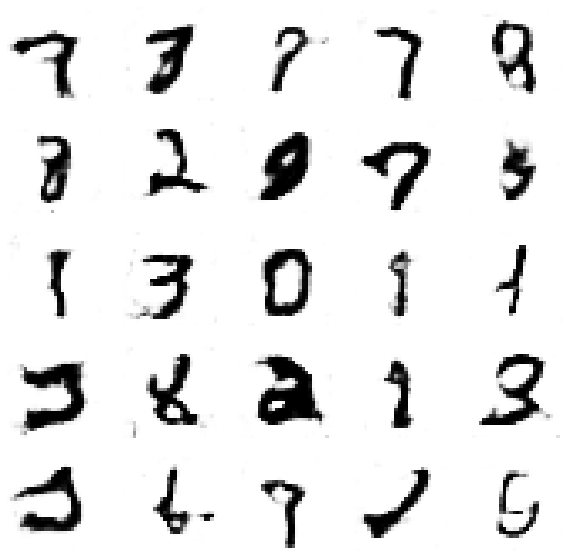

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.2625923784624817, Generator loss 0.5266942738467811
1/1 [==============================] - 0s 23ms/step


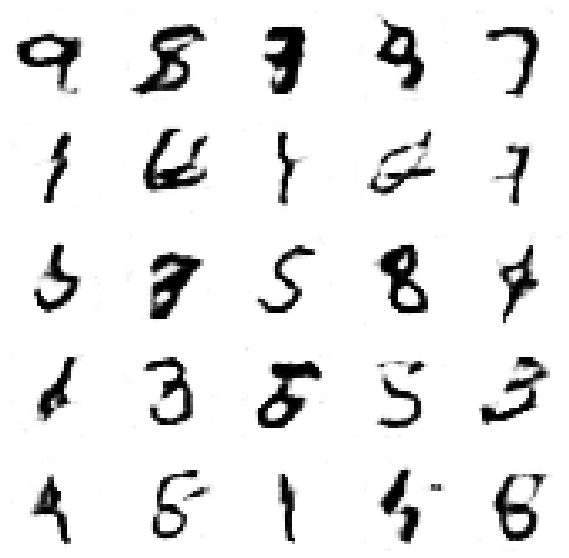

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.2653291708129084, Generator loss 0.5316659940613641
1/1 [==============================] - 0s 20ms/step


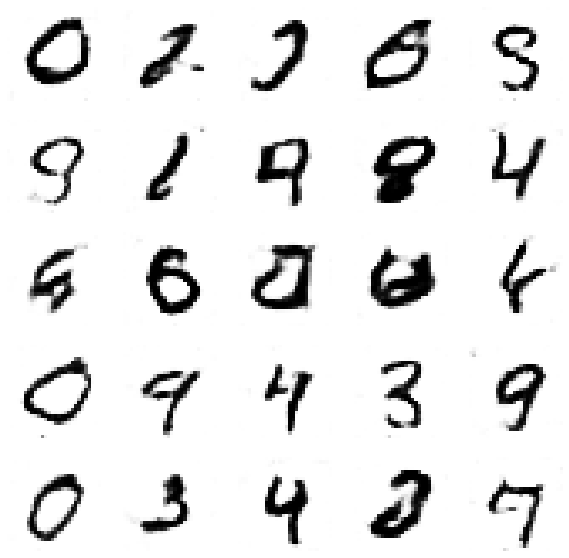

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.26794965819925326, Generator loss 0.5368613829979529
1/1 [==============================] - 0s 20ms/step


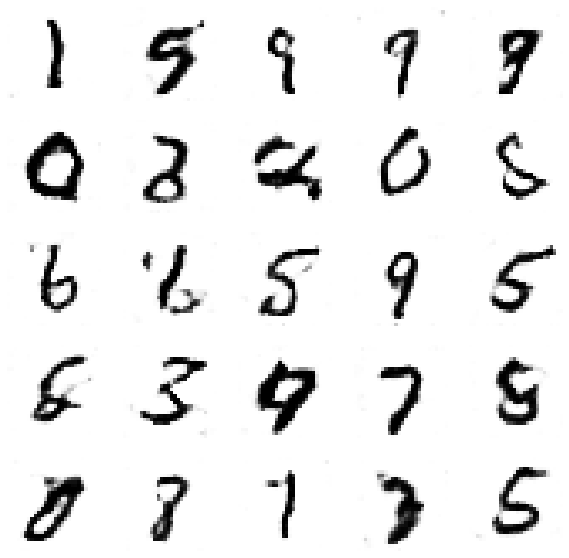

4/4 [==============================] - 0s 8ms/step
Epoch10, Disc loss0.2705384077042596, Generator loss 0.5420367946991553
1/1 [==============================] - 0s 15ms/step


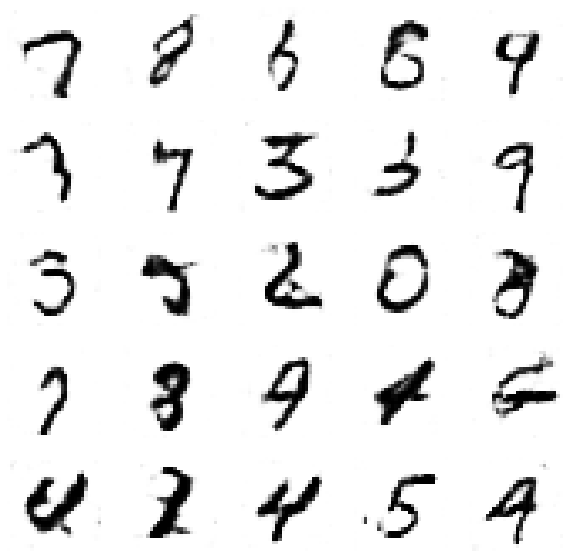

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.2732721444251191, Generator loss 0.5473038564380418
1/1 [==============================] - 0s 15ms/step


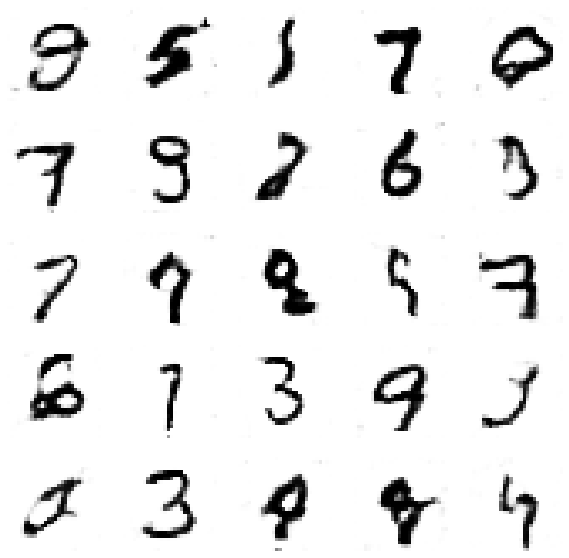

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.27601962842238253, Generator loss 0.5527003285212394
1/1 [==============================] - 0s 15ms/step


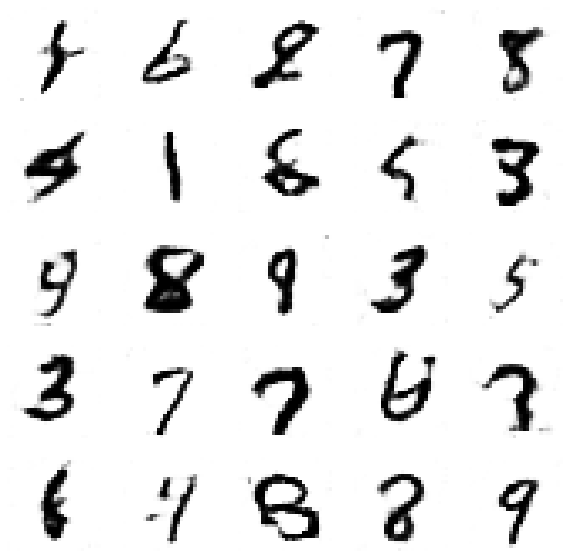

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.2786158862659055, Generator loss 0.5580748182076675
1/1 [==============================] - 0s 27ms/step


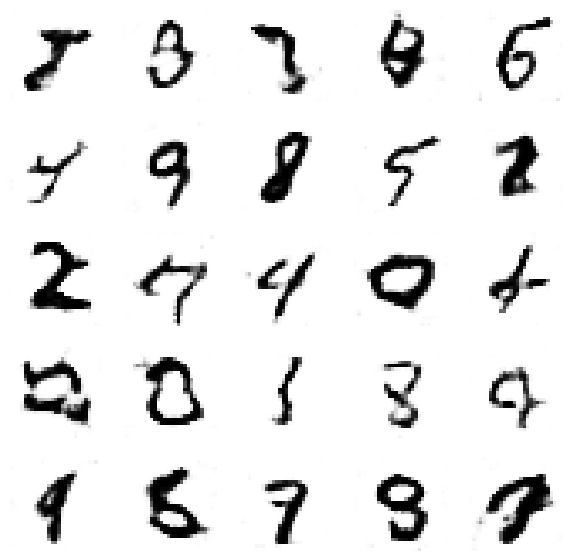

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.28125901628508526, Generator loss 0.5633764124324179
1/1 [==============================] - 0s 28ms/step


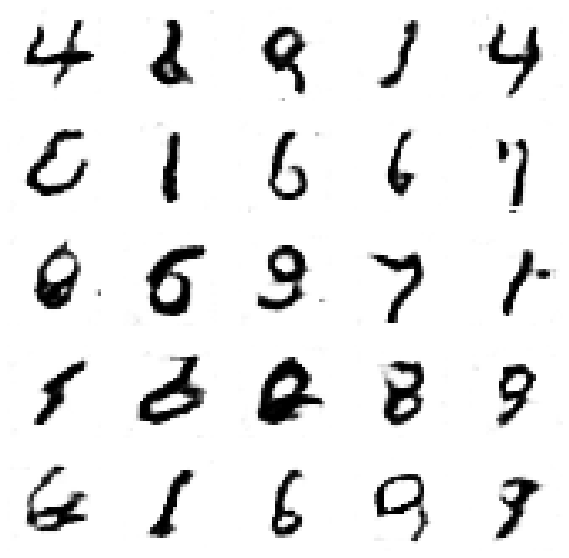

4/4 [==============================] - 0s 5ms/step
Epoch10, Disc loss0.2840422570832774, Generator loss 0.5684988330572079
1/1 [==============================] - 0s 21ms/step


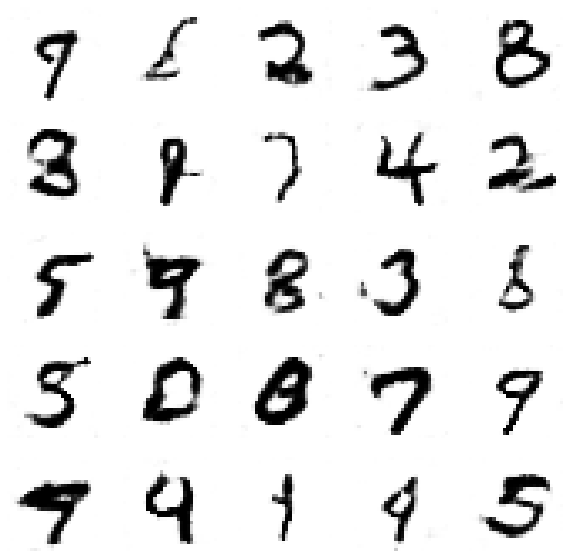

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.28661121357964653, Generator loss 0.5737162558441489
1/1 [==============================] - 0s 15ms/step


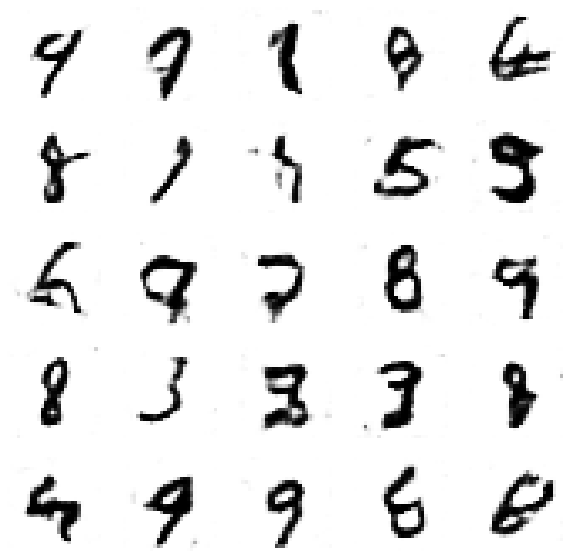

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.2891923379566934, Generator loss 0.5788961246482327
1/1 [==============================] - 0s 15ms/step


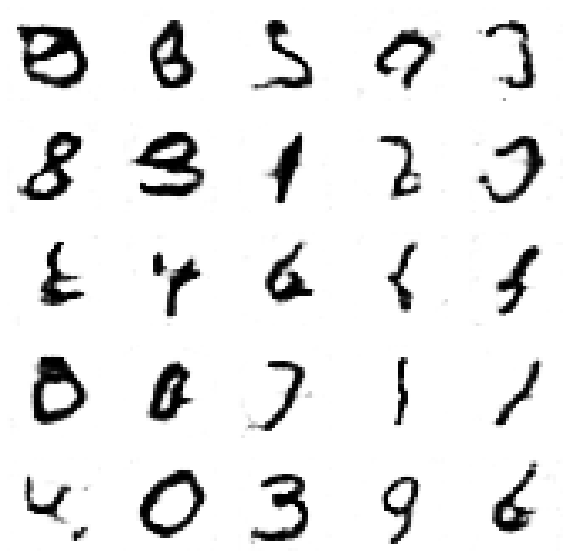

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.2917992207102286, Generator loss 0.5841425652177925
1/1 [==============================] - 0s 22ms/step


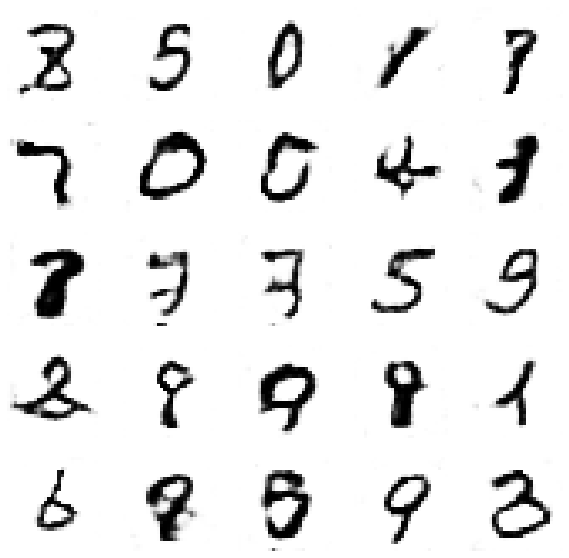

4/4 [==============================] - 0s 9ms/step
Epoch10, Disc loss0.29450117580146873, Generator loss 0.5893280134241805
1/1 [==============================] - 0s 19ms/step


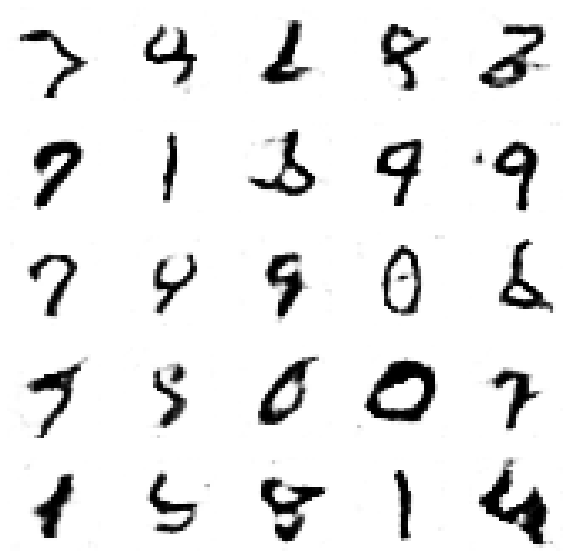

4/4 [==============================] - 0s 6ms/step
Epoch10, Disc loss0.29733550695017874, Generator loss 0.5946360199879377
1/1 [==============================] - 0s 16ms/step


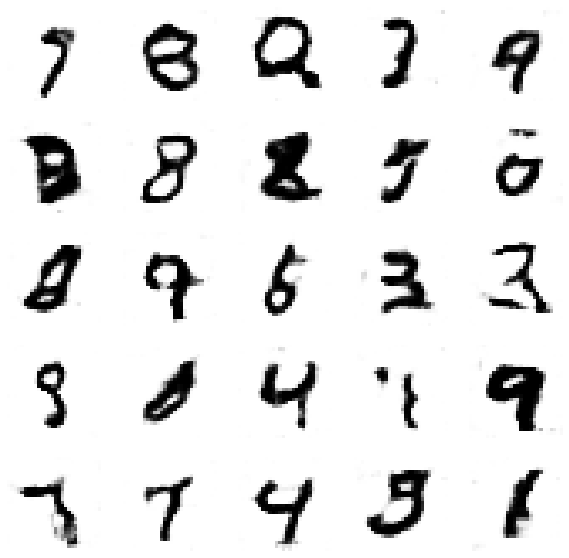

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.29990921870001364, Generator loss 0.6001607790971414
1/1 [==============================] - 0s 15ms/step


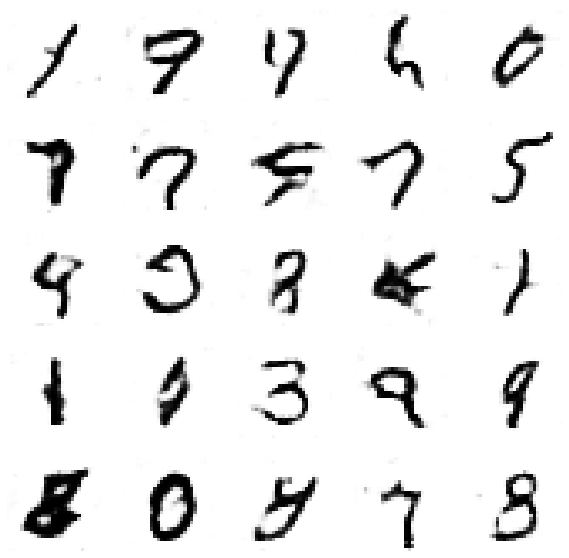

4/4 [==============================] - 0s 4ms/step
Epoch10, Disc loss0.3024765297006338, Generator loss 0.6054459749123989
1/1 [==============================] - 0s 17ms/step


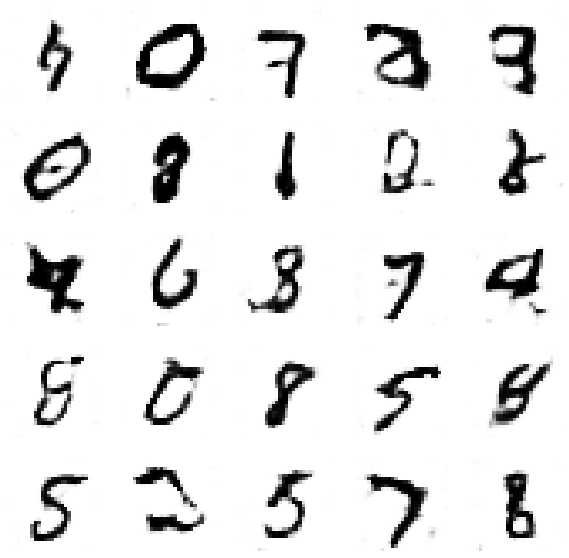

4/4 [==============================] - 0s 3ms/step
Epoch10, Disc loss0.3051359196886038, Generator loss 0.6108690928190182
1/1 [==============================] - 0s 15ms/step


In [ ]:
## Trianing loop

d_losses = []
g_losses = []

for epochs in range(Total_epochs):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  #Mini Batch Gradient Decent

  for step in range(No_of_Batches):
    descriminator.trainable = True
    #get real data
    idx = np.random.randint(0,60000,Half_batch)
    real_imgs = X_train[idx]

    # get fake data
    noise = np.random.normal(0,1, size=(Half_batch,noise_dim))
    fake_imgs = generator.predict(noise)

    # labels
    real_y = np.ones((Half_batch,1))*0.9
    fake_y = np.zeros((Half_batch,1))

    # now train D

    d_loss_real = descriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = descriminator.train_on_batch(fake_imgs, fake_y)

    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
    epoch_d_loss += d_loss

    # Train Generator

    descriminator.trainable = False
    noise = np.random.normal(0,1,size = (Batch_size,noise_dim))

    ground_truth_y = np.ones((Batch_size,1))

    g_loss = model.train_on_batch(noise, ground_truth_y)

    epoch_g_loss += g_loss

    print(f"Epoch{epochs+1}, Disc loss{epoch_d_loss/No_of_Batches}, Generator loss { epoch_g_loss/No_of_Batches}")
    d_losses.append(epoch_d_loss/No_of_Batches)
    g_losses.append(epoch_g_loss/No_of_Batches)


    if (epochs+1) % 10 == 0:
      generator.save("generator.h5")
      display_images()
